In [1]:
"""
@author: pho
"""
## Automatic debugger on exception raised
# %pdb on
%pdb off
%load_ext autoreload
%autoreload 2
# # You need to load the extension first
# %load_ext viztracer

import sys
import importlib
from pathlib import Path
from copy import deepcopy

from numba import jit
import numpy as np
import pandas as pd

import pickle

%config Completer.use_jedi = False

# # required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences()
# np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))
# np.set_printoptions(edgeitems=None, linewidth=100000, formatter=None)
set_pho_preferences_concise()

# For Progress bars:
# from tqdm.notebook import tqdm, trange

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_keys_if_possible, debug_dump_object_member_shapes
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## Plotting Helpers:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()
# DataSessionFormatRegistryHolder.get_registry()

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

## Concise Numpy Array Printing:
# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# # with np.printoptions(precision=2, edgeitems=2, linewidth=144):
# with np.printoptions(precision=3, edgeitems=2, linewidth=100000):
#     # active_computed_data['pf2D'].ratemap
#     print(active_computed_data['pf2D'])
#     # print(active_computed_data['pf2D'].ratemap)
        
# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)

from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, CodeConversion
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData, saveData

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer, override_dict, overriding_dict_with, get_dict_subset
from neuropy.utils.position_util import compute_position_grid_size

# def build_eloy_computation_configs(sess, **kwargs):
#     """ OPTIONALLY can be overriden by implementors to provide specific filter functions """
#     # (4.0, 4.0)cm bins, (6.0, 6.0)cm gaussian smoothing
#     # peak frate > 2Hz 
#     # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(6.0, 6.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
#     # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(2.5, 2.5), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
#     return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]


def build_eloy_computation_configs(sess, **kwargs):
    """ OPTIONALLY can be overriden by implementors to provide specific filter functions """
    # (4.0, 4.0)cm bins, (6.0, 6.0)cm gaussian smoothing
    # peak frate > 2Hz 
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(6.0, 6.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(2.5, 2.5), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]



Automatic pdb calling has been turned OFF


# Load Appropriate Data and begin pipeline

## Bapun Format:

In [2]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
# basedir = r'R:\data\Bapun\RatS\Day5TwoNovel'
basedir = r'W:\Data\Bapun\RatS\Day5TwoNovel'

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir)) # damn this file is 21.1 GB!
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
## _perform_velocity_vs_pf_density_computation: causes AssertionError: After AOC normalization the sum over each cell should be 1.0, but it is not! [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] with 1D placefields!
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

finalized_loaded_sess_pickle_path: W:\Data\Bapun\RatS\Day5TwoNovel\loadedSessPickle.pkl
Loading saved session pickle file results to W:\Data\Bapun\RatS\Day5TwoNovel\loadedSessPickle.pkl... done.
Loading pickled pipeline success: W:\Data\Bapun\RatS\Day5TwoNovel\loadedSessPickle.pkl.
Performing evaluate_single_computation_params on filtered_session with filter named "maze1"...
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
Performing evaluate_single_computation_params on filtered_session with filter named "maze2"...
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.


### Bapun Open-Field Experiment (2022-08-09 Analysis)

Ran into:
`MemoryError: Unable to allocate 63.1 GiB for an array with shape (1738800, 4871) and data type float64`
linear_pos = position_util.linearize_position(active_epoch_pos, method=method)
Occuring in `File c:\users\pho\repos\neuropy\neuropy\utils\position_util.py:42, in linearize_position(position, sample_sec, method, sigma)`
iso_pos = imap.transform(xy_pos)
SOLVED: Solved by omitting the epochs without position data in them!

In [ ]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'W:\Data\Bapun\RatN\Day4OpenField'

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir)) # damn this file is 21.1 GB!
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=False) # TODO: pass a display config

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'R:\data\Rachel\merged_M1_20211123_raw_phy' # Windows

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation']) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [ ]:
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:
## 07:
# basedir = r'/run/media/halechr/MoverNew/data/KDIBA/gor01/one/2006-6-07_11-26-53' # Lab Linux Workstation
# basedir = r'/home/halechr/Data/KDIBA/gor01/one/2006-6-07_11-26-53' # Lab Linux Workstation
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53' # Apogee Windows (R: MoverNew)
basedir = r'W:\Data\KDIBA\gor01\one\2006-6-07_11-26-53' # Apogee Windows (W: Wiser)
## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15' # Apogee Windows

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), override_post_load_functions=[])
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1','maze2','maze'])
active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze2'])

# sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
# 'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
# 'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
#                 }

active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs[0].pf_params.smooth = (0.0, 0.0)
# active_session_computation_configs = build_eloy_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', 
#                                                                                                                        '_perform_position_decoding_computation', '_perform_two_step_position_decoding_computation'], fail_on_exception=True, debug_print=False) # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation'], debug_print=False, fail_on_exception=False) # whitelist: ['_perform_baseline_placefield_computation']
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config

## Hiro Format:

In [ ]:
active_data_mode_name = 'hiro'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
## For data located at:
# W:\Data\Rotation_3_Kamran Diba Lab\DataProcessingProject\Hiro_Datasets

## Data must be pre-processed using the MATLAB script located here: 
#     ./neuropy/data_session_pre_processing_scripts/HIRO/PhoDibaProcess_ComputeSingleExperiment.m
## ALT: alternatively, the original files are located here:
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\PhoDibaProcess_ComputeSingleExperiment.m
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\DEVELOPMENT\NeuroPyExporting2022\PhoNeuroPyConvert_ExportAllToPython_MAIN.m

# From pre-computed .mat files:
## RoyMaze1: 
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze1' # WINDOWS (R: MoverNew)
basedir = r'W:\Data\Hiro\RoyMaze1' # Apogee Windows (W: Wiser)

## RoyMaze2:
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze2' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze2' # WINDOWS
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))

In [ ]:
from neuropy.utils.misc import convert_dataframe_columns_to_datatype_if_possible, add_explicit_dataframe_columns_from_lookup_df

## Finish setting up the spikes_df:
curr_active_pipeline.sess.spikes_df.spikes.set_time_variable_name("t_seconds")
curr_active_pipeline.sess.flattened_spiketrains._spikes_df = add_explicit_dataframe_columns_from_lookup_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.neurons._extended_neuron_properties_df).sort_values(by=['t_seconds']) # Need to re-sort by timestamps once done
convert_dataframe_columns_to_datatype_if_possible(curr_active_pipeline.sess.spikes_df, {'int':['shank', 'cluster', 'aclu', 'qclu', 'traj', 'lap']})

In [ ]:
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = active_data_mode_registered_class.build_track_only_filter_functions(sess=curr_active_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_track_only_pyramidal(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs

In [ ]:
post_filter_fn = active_session_filter_configurations['track']


active_session_filter_configurations['track'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1'))

In [ ]:
curr_active_pipeline.sess.flattened_spiketrains._time_variable_name

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

In [ ]:
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_blacklist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=True)
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

In [ ]:
def _debug_print_spikes_df_column_info(spikes_df):
    print(f'.columns: {list(spikes_df.columns)}')
    print(f'.spikes.time_variable_name: {spikes_df.spikes.time_variable_name}')    

In [ ]:
# curr_active_pipeline.sess.spikes_df.columns
# curr_active_pipeline.sess.spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.sess.spikes_df)

In [ ]:
# curr_active_pipeline.filtered_sessions['track'].spikes_df.columns
# curr_active_pipeline.filtered_sessions['track'].spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.filtered_sessions['track'].spikes_df)

In [ ]:
curr_active_pipeline.sess.neurons._extended_neuron_properties_df

In [ ]:
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.utils.misc import print_seconds_human_readable


debug_print_spike_counts(sess)

### Logging detour:

In [ ]:
## TODO: ONLY RUN ONCE!
import logging
logging.captureWarnings(False)
logger = logging.getLogger("com.PhoHale")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
root_logger = logging.root

In [ ]:
root_logger.handlers

In [ ]:
# logger.removeHandler(logging.StreamHandler(stream=sys.stdout))
for a_handler in logger.handlers:
    logger.removeHandler(a_handler)

In [ ]:
logger.info('creating an instance of auxiliary_module.Auxiliary')
logger.debug('UOS')
logger.warning('OH NO!')

## Fix Format session config's potential 'format_name' property issue which was added after pickling. 2022-08-10

In [13]:
# Ensures that the session config has the 'format_name' property which was added after pickling.

def ensure_unpickled_pipeline_up_to_date(curr_active_pipeline, active_data_mode_name, basedir, desired_time_variable_name, debug_print=False):
    """ Ensures that all sessions in the pipeline are valid after unpickling, and updates them if they aren't.
    # TODO: NOTE: this doesn't successfully save the changes to the spikes_df.time_variable_name to the pickle (or doesn't load them). This probably can't be pickled and would need to be set on startup.
    
    Usage:
        
        desired_time_variable_name = active_data_mode_registered_class._time_variable_name # Requires desired_time_variable_name
        pipeline_needs_resave = _ensure_unpickled_session_up_to_date(curr_active_pipeline, active_data_mode_name=active_data_mode_name, basedir=basedir, desired_time_variable_name=desired_time_variable_name, debug_print=False)

        ## Save out the changes to the pipeline after computation to the pickle file for easy loading in the future
        if pipeline_needs_resave:
            curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle.pkl')
        else:
            print(f'property already present in pickled version. No need to save.')
    
    """
    def _ensure_unpickled_session_up_to_date(a_sess, active_data_mode_name, basedir, desired_time_variable_name, debug_print=False):
        """ makes sure that the passed in session which was loaded from a pickled pipeline has the required properties and such set. Used for post-hoc fixes when changes are made after pickling. """
        did_add_property = False
        if not hasattr(a_sess.config, 'format_name'):
            did_add_property = True
            a_sess.config.format_name = active_data_mode_name
        if (a_sess.basepath != Path(basedir)):
            did_add_property = True
            a_sess.config.basepath = Path(basedir)
        if desired_time_variable_name != a_sess.spikes_df.spikes.time_variable_name:
            if debug_print:
                print(f'a_sess.spikes_df.spikes.time_variable_name: {a_sess.spikes_df.spikes.time_variable_name}')
            # did_add_property = True
            a_sess.spikes_df.spikes.set_time_variable_name(desired_time_variable_name)
        return did_add_property

    did_add_property = False
    did_add_property = did_add_property or ensure_unpickled_session_up_to_date(curr_active_pipeline.sess, active_data_mode_name=active_data_mode_name, basedir=basedir, desired_time_variable_name=desired_time_variable_name, debug_print=debug_print)
    ## Apply to all of the pipeline's filtered sessions:
    for a_sess in curr_active_pipeline.filtered_sessions.values():
        did_add_property = did_add_property or ensure_unpickled_session_up_to_date(a_sess, active_data_mode_name=active_data_mode_name, basedir=basedir, desired_time_variable_name=desired_time_variable_name, debug_print=debug_print)
    return did_add_property
    
    
desired_time_variable_name = active_data_mode_registered_class._time_variable_name # Requires desired_time_variable_name
pipeline_needs_resave = _ensure_unpickled_session_up_to_date(curr_active_pipeline, active_data_mode_name=active_data_mode_name, basedir=basedir, desired_time_variable_name=desired_time_variable_name, debug_print=False)

## Save out the changes to the pipeline after computation to the pickle file for easy loading in the future
if pipeline_needs_resave:
    curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle.pkl')
else:
    print(f'property already present in pickled version. No need to save.')

property already present in pickled version. No need to save.
Found a group with the identifier Nested Outer Widget: maze1 containing 1 items. Removing all...


## 💾 Save out the changes to the pipeline after computation to the pickle file for easy loading in the future:

# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [4]:
# %%viztracer
active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {list(active_computed_data.keys())}')
print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']    
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_extended_stats = curr_active_pipeline.computation_results[active_config_name].computed_data.get('extended_stats', None)
active_eloy_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('EloyAnalysis', None)
active_simpler_pf_densities_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('SimplerNeuronMeetingThresholdFiringAnalysis', None)
active_ratemap_peaks_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', None)
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

display_output = dict()

active_computed_data.keys(): ['pf1D', 'pf2D', 'pf1D_dt', 'pf2D_dt', 'pf2D_Decoder', 'pf2D_TwoStepDecoder', 'RatemapPeaksAnalysis', 'extended_stats', 'placefield_overlap', 'firing_rate_trends']
active_computation_errors: {}


In [ ]:
list(active_computation_errors.values())[0]

In [ ]:
err_fn = list(active_computation_errors.keys())[0]
err_fn

In [ ]:
err_fn.__name__ # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'

In [ ]:
# sess.epochs #  20756  24004  maze2      3248
curr_active_pipeline.filtered_epochs
# sess.spikes_df # ['flat_spike_idx', 't_seconds', 'aclu', 'unit_id', 'shank_id', 'flattened_spike_linear_unit_spike_idx', 'cell_type', 'x', 'y', 'lin_pos', 'speed', 'fragile_linear_neuron_IDX', 'neuron_IDX', 't', 'PBE_id', 'scISI', 'shank', 'qclu', 'cluster']

In [ ]:
## Save out the changes to the pipeline after computation to the pickle file for easy loading in the future
curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle.pkl')

# Main Visualization GUIs

## 3D Interactive Spike Raster Window

In [ ]:
# sess.spikes_df.spikes.time_variable_name
active_data_mode_registered_class._time_variable_name
# active_data_mode_type_properties

In [ ]:
%pdb on
# %pdb off

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_config_name, active_config_name=active_config_name)
spike_raster_window = display_output['spike_raster_window']

In [ ]:
spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, application_name=f'Spike Raster Window - {active_config_name}')
# Set Window Title Options:
spike_raster_window.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window.setWindowTitle(f'Spike Raster Window - {active_config_name} - {str(sess.filePrefix.resolve())}')

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=provided_neuron_id_to_color_map)

In [ ]:
# Setup Connections Menu:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(spike_raster_window) # none of these properties need to be 

### Test building a second spike_raster_window for a different epoch:

In [ ]:
secondary_active_config_name = 'maze2'
secondary_spikes_df = curr_active_pipeline.filtered_sessions[secondary_active_config_name].spikes_df
spike_raster_window_second_epoch = Spike3DRasterWindowWidget(secondary_spikes_df, application_name=f'Spike Raster Window - {secondary_active_config_name}', type_of_3d_plotter='vedo')
# Set Window Title Options:
spike_raster_window_second_epoch.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window_second_epoch.setWindowTitle(f'Spike Raster Window - {secondary_active_config_name} - {str(sess.filePrefix.resolve())}')
spike_raster_window_second_epoch

In [ ]:
spike_raster_window.spikes_df # has scISI column!


In [ ]:
spike_raster_window.connection_man

In [ ]:
spike_raster_window.connection_man.active_connections

In [ ]:
spike_raster_window.connection_man.get_available_drivers()

### 2D Raster Plot Interactivity Testing/Extras

In [ ]:
# spike_raster_window.render_window_duration
# spike_raster_window.spikes_window.active_window_end_time
spike_raster_window.spikes_window.window_duration

In [ ]:
### Debug printing for color properties of spike_raster_window
_debug_params = spike_raster_window.spike_raster_plt_2d.params
# _debug_params.neuron_colors
# _debug_params.config_items
# spike_raster_window.params

In [ ]:
# Wanted to try to set setClickable(True) on the children widgets

# spike_raster_window.spike_raster_plt_2d.plots # {'name': '', 'preview_overview_scatter_plot': <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem object at 0x0000020AA96D9E50>}
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.PlotItem.PlotItem.PlotItem at 0x20aecdf0ee0>
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves # [<pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem at 0x20aa92a5820>]

# Static Background Overview Scatter Plot:
active_overview_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.preview_overview_scatter_plot # ScatterPlotItem 
# active_overview_scatter_plot.addPoints(hoverable=True)

## Main Scatter Plot 
main_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves[0] # ScatterPlotItem 
# main_scatter_plot.setAcceptHoverEvents(True)

# Common Tick Label
vtick = QtGui.QPainterPath()
vtick.moveTo(0, -0.5)
vtick.lineTo(0, 0.5)

# # Highlights the hovered spikes white:
# main_scatter_plot.addPoints(hoverable=True,
#     hoverSymbol=vtick, # hoverSymbol='s',
#     hoverSize=7, # default is 5
#     hoverPen=pg.mkPen('w', width=2),
#     hoverBrush=pg.mkBrush('w'))

# Highlights the hovered spikes white:
main_scatter_plot.addPoints(hoverable=True,
    # hoverSymbol=vtick, # hoverSymbol='s',
    hoverSize=7, # default is 5
    )


## Clickable/Selectable Spikes:
# Will make all plots clickable
clickedPen = pg.mkPen('#DDD', width=2)
lastClicked = []
def _test_scatter_plot_clicked(plot, points):
    global lastClicked
    for p in lastClicked:
        p.resetPen()
    print("clicked points", points)
    for p in points:
        p.setPen(clickedPen)
    lastClicked = points
        
## Hoverable Spikes:
def _test_scatter_plot_hovered(plt, points, ev):
    # sigHovered(self, points, ev)
    print(f'_test_scatter_plot_hovered(plt: {plt}, points: {points}, ev: {ev})')
    if (len(points) > 0):
        curr_point = points[0]
        # self.
        # curr_point.index

main_scatter_hovered_connection = main_scatter_plot.sigHovered.connect(_test_scatter_plot_hovered)
main_scatter_clicked_connection = main_scatter_plot.sigClicked.connect(_test_scatter_plot_clicked)

# tip
# .sigHovered 
# TypeError: 'VisualizationParameters' object is not subscriptable

In [ ]:
## Test Adding ROIs of interest to the 2D Raster Plot:
rois = []
rois.append(pg.MultiRectROI([[20, 90], [50, 60], [60, 90]], width=5, pen=(2,9)))

def update(roi):
    img1b.setImage(roi.getArrayRegion(arr, img1a), levels=(0, arr.max()))
    v1b.autoRange()
    
for roi in rois:
    roi.sigRegionChanged.connect(update)
    v1a.addItem(roi)

In [ ]:
curve.curve.setClickable(True)

## ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [ ]:
pActiveTuningCurvesPlotter = None

zScalingFactor = 2000.0 # worked well before with default params
# zScalingFactor = 50.0 # worked well before with default params
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=zScalingFactor, separate_window=False)
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

### Setup Extra Buttons

In [ ]:
ipcDataExplorer.occupancy_plotting_config.barOpacity = 0.25

In [ ]:
placefieldControlsContainerWidget.ui.end_button_helper_connections

In [ ]:
ipcDataExplorer.plots


ipcDataExplorer.zScalingFactor = 100

### Prototype updating the displayed placefield values with those generated from a time-dependent pf_2D_dt

In [ ]:
## Update the time-dependent pf:
active_pf_2D_dt.reset()

## Find the neuron_IDs that are included in the active_pf_2D for filtering the active_pf_2D_dt's results:
is_pf_2D_included_neuron = np.isin(active_pf_2D_dt.included_neuron_IDs, active_pf_2D.included_neuron_IDs)
pf_2D_included_neuron_indx = active_pf_2D_dt._included_thresh_neurons_indx[is_pf_2D_included_neuron]
active_pf_2D_dt._included_thresh_neurons_indx = pf_2D_included_neuron_indx
active_pf_2D_dt._peak_frate_filter_function = lambda list_: [list_[_] for _ in active_pf_2D_dt._included_thresh_neurons_indx]

earliest_pos_t = active_pf_2D_dt.all_time_filtered_pos_df['t'].values[0]
print(f'earliest_pos_t: {earliest_pos_t}')
# active_pf_2D_dt.update(t=earliest_pos_t)
# active_pf_2D_dt.step(num_seconds_to_advance=6000.0)

last_pos_t = active_pf_2D_dt.all_time_filtered_pos_df['t'].values[-1]
print(f'last_pos_t: {last_pos_t}')
# active_pf_2D_dt.update(t=last_pos_t)

# active_pf_2D_dt.update(t=earliest_pos_t+(60.0 * 5.0))
active_pf_2D_dt.update(t=3000000.0)
print(f'post-update time: {active_pf_2D_dt.last_t}')

# earliest_pos_t: 22.26785500004189
# last_pos_t: 1739.1316560000414
# post-update time: 322.2678550000419

In [ ]:
## Asserts to make sure that the fully-updated dt is equal to the normal:
assert active_pf_2D_dt.all_time_filtered_pos_df.shape == active_pf_2D_dt.filtered_pos_df.shape, f"active_pf_2D_dt.all_time_filtered_pos_df.shape: {active_pf_2D_dt.all_time_filtered_pos_df.shape}\nactive_pf_2D_dt.filtered_pos_df.shape: {active_pf_2D_dt.filtered_pos_df.shape} "
assert active_pf_2D_dt.all_time_filtered_spikes_df.shape == active_pf_2D_dt.filtered_spikes_df.shape, f"active_pf_2D_dt.all_time_filtered_spikes_df.shape: {active_pf_2D_dt.all_time_filtered_spikes_df.shape}\nactive_pf_2D_dt.filtered_spikes_df.shape: {active_pf_2D_dt.filtered_spikes_df.shape} "
# Occupancies are equal:

assert np.isclose(active_pf_2D_dt.ratemap.occupancy, active_pf_2D.ratemap.occupancy).all(), f"active_pf_2D_dt.ratemap.occupancy: {active_pf_2D_dt.ratemap.occupancy}\nactive_pf_2D.ratemap.occupancy: {active_pf_2D.ratemap.occupancy}"
# assert (active_pf_2D_dt.ratemap.occupancy == active_pf_2D.ratemap.occupancy).all(), f"active_pf_2D_dt.ratemap.occupancy: {active_pf_2D_dt.ratemap.occupancy}\nactive_pf_2D.ratemap.occupancy: {active_pf_2D.ratemap.occupancy}"
assert (active_pf_2D_dt.ratemap.spikes_maps == active_pf_2D.ratemap.spikes_maps).all(), f"active_pf_2D_dt.ratemap.spikes_maps: {active_pf_2D_dt.ratemap.spikes_maps}\nactive_pf_2D.ratemap.spikes_maps: {active_pf_2D.ratemap.spikes_maps}"

In [ ]:
assert (active_pf_2D_dt.ratemap.tuning_curves == active_pf_2D.ratemap.tuning_curves).all(), f"active_pf_2D_dt.ratemap.tuning_curves: {active_pf_2D_dt.ratemap.tuning_curves}\nactive_pf_2D.ratemap.tuning_curves: {active_pf_2D.ratemap.tuning_curves}"

In [ ]:
active_pf_2D_dt.should_smooth_final_tuning_map

In [ ]:
PfND_ .should_smooth_spikes_map

In [ ]:
active_pf_2D_dt.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

In [ ]:
active_pf_2D.plot_ratemaps_2D(**({'subplots': (None, 9), 'resolution_multiplier': 1.0, 'enable_spike_overlay': False}))

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_common_setup
# Get flat list of images:
images = active_pf_2D.ratemap.tuning_curves # (43, 63, 63)
occupancy = active_pf_2D.ratemap.occupancy

# images = active_pf_2D_dt.ratemap.tuning_curves # (43, 63, 63)
# images = active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_pf_2D_dt.curr_smoothed_spikes_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
# occupancy = active_pf_2D_dt.ratemap.occupancy
# occupancy = active_pf_2D_dt.curr_seconds_occupancy
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_2D_dt.xbin, active_pf_2D_dt.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)

parent_root_widget.show()

In [ ]:
def debug_show_placefields(pf_type: str, images, occupancy):
    if pf_type == 'dt':
        active_pfs = active_pf_2D_dt
    else:
        active_pfs =  active_pf_2D
    app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pfs.xbin, active_pfs.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)
    parent_root_widget.show()
    return dict(app=app, parent_root_widget=parent_root_widget, root_render_widget=root_render_widget, plot_array=plot_array, img_item_array=img_item_array, other_components_array=other_components_array)


debug_pf_dict = debug_show_placefields('', active_pf_2D.ratemap.tuning_curves, active_pf_2D.ratemap.occupancy)

In [ ]:
debug_pf_dt_dict = debug_show_placefields('dt', active_pf_2D_dt.ratemap.tuning_curves, active_pf_2D_dt.ratemap.occupancy)

In [ ]:
active_pf_2D.should_smooth_spatial_occupancy_map
active_pf_2D_dt.should_smooth_spatial_occupancy_map

active_pf_2D_dt.included_neuron_IDs

In [ ]:


assert (active_pf_2D_dt.ratemap.spikes_maps == active_pf_2D.ratemap.spikes_maps).all(), f"active_pf_2D_dt.ratemap.spikes_maps: {active_pf_2D_dt.ratemap.spikes_maps}\nactive_pf_2D.ratemap.spikes_maps: {active_pf_2D.ratemap.spikes_maps}"

In [ ]:
active_pf_2D_dt._included_thresh_neurons_indx

In [ ]:
active_pf_2D.ratemap.occupancy

In [ ]:
active_pf_2D_dt.curr_seconds_occupancy

In [ ]:
active_pf_2D_dt.ratemap.occupancy

In [ ]:
active_pf_2D.ratemap.tuning_curves

In [ ]:
active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[~active_pf_2D_dt._included_thresh_neurons_indx,:,:].nonzero()] # [4602, 4602, 4602], there are [2441, 2441, 2441] outside the included

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D.ratemap.tuning_curves.nonzero()] # [67595, 67595, 67595]

In [ ]:
active_pf_2D_dt.ratemap.tuning_curves

In [ ]:
active_pf_2D.ratemap.spikes_maps.nonzero()

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D.ratemap.tuning_curves.nonzero()] # [67595, 67595, 67595]

In [ ]:
active_pf_2D_dt.last_t

In [ ]:
active_pf_2D_dt.ratemap.tuning_curves

In [ ]:
active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
active_pf_2D_dt.ratemap.neuron_ids

In [ ]:
# %pdb on
pActiveTuningCurvesPlotter_dup = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, override_pf2D=active_pf_2D_dt , extant_plotter=display_output.get('pActiveTuningCurvesPlotter_dup', None),
                                                               panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=2000.0) # Works now!
ipcDataExplorer_dup = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter_dup'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter_dup = display_output['pActiveTuningCurvesPlotter_dup']
root_dockAreaWindow_dup, placefieldControlsContainerWidget_dup, pf_widgets_dup = display_output['pane'] # for Qt mode:

In [ ]:
# %pdb on
# %pdb off
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
from pyphoplacecellanalysis.GUI.Qt.Mixins.Menus.ConnectionControlsMenuMixin import ConnectionControlsMenuMixin

from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers
from pyphoplacecellanalysis.General.Configs.DynamicConfigs import PlottingConfig, InteractivePlaceCellConfig
from pyphocorehelpers.mixins.member_enumerating import AllFunctionEnumeratingMixin
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder

pActiveTuningCurvesPlotter_dup = None
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import DockAreaWrapper

# Qt-based Placefield controls:
from pyphoplacecellanalysis.GUI.Qt.PlacefieldVisualSelectionControls.qt_placefield import build_all_placefield_output_panels
# ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_computed_data['pf2D'], curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))
ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_computed_data['pf2D_dt'], curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))

# ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_pf_2D_dt, curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))
pActiveTuningCurvesPlotter_dup = ipcDataExplorer_dup.plot(pActiveTuningCurvesPlotter_dup) # [2, 17449]
# Update the ipcDataExplorer's colors for spikes and placefields from its configs on init:
ipcDataExplorer_dup.on_config_update({neuron_id:a_config.color for neuron_id, a_config in ipcDataExplorer_dup.active_neuron_render_configs_map.items()}, defer_update=False)

# build the output panels if desired:
# pane: (placefieldControlsContainerWidget, pf_widgets)
placefieldControlsContainerWidget_dup, pf_widgets = build_all_placefield_output_panels(ipcDataExplorer_dup)
placefieldControlsContainerWidget_dup.show()

# Adds the placefield controls container widget and each individual pf widget to the ipcDataExplorer.ui in case it needs to reference them later:
ipcDataExplorer_dup.ui['placefieldControlsContainerWidget'] = placefieldControlsContainerWidget_dup

# Visually align the widgets:
WidgetPositioningHelpers.align_window_edges(ipcDataExplorer_dup.p, placefieldControlsContainerWidget_dup, relative_position = 'above', resize_to_main=(1.0, None))

# Wrap:
active_root_main_widget = ipcDataExplorer_dup.p.window()
root_dockAreaWindow, app = DockAreaWrapper.wrap_with_dockAreaWindow(active_root_main_widget, placefieldControlsContainerWidget_dup, title=ipcDataExplorer_dup.data_explorer_name)

pane = (root_dockAreaWindow, placefieldControlsContainerWidget_dup, pf_widgets)



In [ ]:
# ## Update existing open ipcDataExplorer by overwriting (TODO):
# ipcDataExplorer.params.active_epoch_placefields = active_pf_2D_dt

### Optional Duplicate ipcDataExplorer plotter for comparison

In [ ]:
pActiveTuningCurvesPlotter_dup = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, override_pf2D= , extant_plotter=display_output.get('pActiveTuningCurvesPlotter_dup', None),
                                                               panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=2000.0) # Works now!
ipcDataExplorer_dup = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter_dup'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter_dup = display_output['pActiveTuningCurvesPlotter_dup']
root_dockAreaWindow_dup, placefieldControlsContainerWidget_dup, pf_widgets_dup = display_output['pane'] # for Qt mode:

### Render computed contours and peaks to ipcDataExplorer:

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.peak_prominences import render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter
## Call the function to add the 3D plot components to the pyvista plotter
render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter(ipcDataExplorer, active_peak_prominence_2d_results, debug_print=False)

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=ipcDataExplorer.active_neuron_render_configs_map)

In [ ]:
ipcDataExplorer.p.enable_depth_peeling(10, occlusion_ratio=0) # This fixes many of the rendering issues of the placefields, but does slow things way down. 
# ipcDataExplorer.p.enable_depth_peeling(number_of_peels=4, occlusion_ratio=0)
# ipcDataExplorer.p.disable_depth_peeling()
# ipcDataExplorer.p.enable_depth_peeling(10)

In [ ]:
## Change background color:
ipcDataExplorer.params.plotter_backgrounds

In [ ]:
ipcDataExplorer.set_background('Deep Space (Dark)')

In [ ]:
ipcDataExplorer.set_background('Purple Paradise')

In [ ]:
ipcDataExplorer.plot_placefields()

In [ ]:
ipcDataExplorer.params.zScalingFactor

In [ ]:
# ipcDataExplorer.toggle_plot_visibility() # Looks like it works for generally specified plot key
# ipcDataExplorer.get_plot_objects_list

# ['main', 'points', 'peaks']
list(ipcDataExplorer.tuning_curve_plot_actors[2].keys())
# 'tuningCurvePlotActors'

In [ ]:
curr_tuning_curve_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][2]
curr_pdata = curr_tuning_curve_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid
curr_pdata_points = curr_tuning_curve_data['pdata_currActiveNeuronTuningCurve_Points'] # UnstructuredGrid
curr_pdata_points
# curr_pdata
# {'curr_active_neuron_ID': 2,
#  'curr_active_neuron_pf_identifier': 'pf[2]',
#  'curr_active_neuron_tuning_Curve': array([[0.437126, 0.818305, 1.48319, ..., 0.0155238, 0.0067005, 0.00294359],
#         [0.347969, 0.64914, 1.17457, ..., 0.0388841, 0.0167967, 0.00739304],
#         [0.228976, 0.415578, 0.741638, ..., 0.0922773, 0.0399187, 0.0176301],
#         ...,
#         [0, 0, 0, ..., 0.0989772, 0.0683015, 0.0467108],
#         [0, 0, 0, ..., 0.0407058, 0.0284058, 0.0195678],
#         [0, 0, 0, ..., 0.0158926, 0.0112009, 0.00776478]]),
#  'pdata_currActiveNeuronTuningCurve': StructuredGrid (0x24d816a7f40)
#    N Cells:	1764
#    N Points:	1856
#    X Bounds:	2.581e+01, 2.638e+02
#    Y Bounds:	1.244e+02, 1.536e+02
#    Z Bounds:	0.000e+00, 1.703e+01
#    Dimensions:	29, 64, 1
#    N Arrays:	3,
#  'pdata_currActiveNeuronTuningCurve_Points': UnstructuredGrid (0x24d815b4dc0)
#    N Cells:	1716
#    N Points:	1812
#    X Bounds:	2.581e+01, 2.638e+02
#    Y Bounds:	1.244e+02, 1.536e+02
#    Z Bounds:	0.000e+00, 1.703e+01
#    N Arrays:	3,
#  'lut': <vtkmodules.vtkCommonCore.vtkLookupTable(0x0000024D9A888950) at 0x0000024DAA8F35E0>,
#  'peaks':
#  ...

surf = curr_pdata.extract_surface() # <class 'pyvista.core.pointset.PolyData'>
surf

# surf = curr_pdata_points.reconstruct_surface() # this does not work at all
# surf
# curr_pdata_points.length

# active_points_data = curr_pdata_points.points.copy()
# active_points_data = curr_pdata.copy()
active_points_data = surf.copy()
origin = active_points_data.center.copy()
origin[-1] = origin[-1] - (active_points_data.length/3.0)
origin
projected = active_points_data.project_points_to_plane(origin=origin)
projected

In [ ]:
edges = curr_pdata.extract_all_edges()
edges.plot(line_width=1, color='k')

In [ ]:
# non_visited_mask = active_placefields.never_visited_occupancy_mask
non_visited_mask = ipcDataExplorer.params.active_epoch_placefields.never_visited_occupancy_mask.copy()
non_visited_mask

In [ ]:
flat_non_visited_mask = non_visited_mask.T.copy().ravel(order="F")
# flat_non_visited_mask.shape # (1856,)

In [ ]:
# Only if VTK > 9.1.X does this return a PointData, otherwise returns None
# _ = curr_pdata.hide_points(ind=flat_non_visited_mask)
curr_pdata.hide_cells(flat_non_visited_mask, inplace=True)
# curr_updated_pdata_points = curr_pdata_points.hide_points(non_visited_mask).copy()
# curr_updated_pdata_points
# List or array of point indices to be hidden. The array can also be a boolean array of the same size as the number of points.


In [ ]:
import pyvista as pv
pl = pv.Plotter(shape=(1,2))
pl.add_mesh(curr_pdata_points)
pl.add_title('points')
pl.subplot(0,1)
pl.add_mesh(curr_pdata, color=True, show_edges=True)
pl.add_mesh(surf, color=True, show_edges=True)
pl.add_mesh(projected)
pl.add_mesh(curr_pdata)
pl.add_title('reconstructed from points')
pl.show()

In [ ]:
curr_tuning_curve_plot = ipcDataExplorer.tuning_curve_plot_actors[2]['main']
curr_tuning_curve_plot.GetShaderProperty()

In [ ]:
sess_spikes_df

### Test Programmatically Adding GUI/UI controls for additional plots (Occupancy, etc)

In [ ]:
# ipcDataExplorer.ui.placefieldControlsContainerWidget # PlacefieldVisualSelectionControlsBarWidget
# ipcDataExplorer.ui.placefieldControlsContainerWidget.ui.pf_layout # QHBoxLayout 
curr_neuron_widget = ipcDataExplorer.ui.placefieldControlsContainerWidget.ui.pf_widgets[0] # Grab single neuron widget (PlacefieldVisualSelectionWidget)
curr_layout = curr_neuron_widget.ui.groupBox.layout() # QVBoxLayout 

In [ ]:
chkbtnProminenceMetrics = curr_neuron_widget.build_ui_toggle_button(name='chkbtnProminenceMetrics', text='prominences', parent=curr_neuron_widget.ui.groupBox)
curr_layout.addWidget(chkbtnProminenceMetrics)

<!-- ### Occupancy Toggle -->

In [ ]:
# ipcDataExplorer.on_occupancy_plot_update_visibility
ipcDataExplorer.occupancy_plotting_config.isVisible = False

In [ ]:
ipcDataExplorer.plot_occupancy_bars()

In [ ]:
ipcDataExplorer.occupancy_plotting_config.labelsAreVisible = True # Setting this to true renders the labels at each occupancy bin

In [ ]:
ipcDataExplorer.occupancy_plotting_config.labelsShowPoints = True

In [ ]:
ipcDataExplorer.params.should_nan_non_visited_elements = False

In [ ]:
filtered_indices = sess_spikes_df.index.values[active_pf_2D.filtered_spikes_df.index]
# filtered_sess_spikes_df = sess_spikes_df[sess_spikes_df.index == active_pf_2D.filtered_spikes_df.index]
# filtered_sess_spikes_df = sess_spikes_df[sess_spikes_df['flat_spike_idx'] == active_pf_2D.filtered_spikes_df.flat_spike_idx]
# filtered_sess_spikes_df

In [ ]:
ipcDataExplorer.occupancy_plotting_config.isVisible = False

In [ ]:
ipcDataExplorer.occupancy_plotting_config

### Explore Mesh/Cell Picking in ipcDataExplorer

In [ ]:
## Make the legend pickable:
import pyvista as pv

def callback(point):
    """Create a cube and a label at the click point."""
    mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])


ipcDataExplorer.p.enable_surface_picking(callback=callback, left_clicking=True, show_point=False)
# ipcDataExplorer.p.enable_surface_picking(

In [ ]:
def mesh_picked_callback(mesh):
    """TODO: highlight the mesh or something - label at the click point."""
    print(f'mesh_picked_callback(mesh: {mesh})')
    # mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    # ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    # ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])

ipcDataExplorer.p.enable_mesh_picking(callback=mesh_picked_callback, left_clicking=True, show=True)

### Other

In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
app, win, w = curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', active_config_name)
win.show(); pg.exec()

## ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [ ]:
pActiveSpikesBehaviorPlotter = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name, extant_plotter=display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = display_output['ipspikesDataExplorer']
display_output['pActiveSpikesBehaviorPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = display_output['pActiveSpikesBehaviorPlotter']

In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

### Test Programmatic Updating of the ipspikesDataExplorer

In [ ]:
ipspikesDataExplorer.spikes_main_historical.VisibilityOff()
# ipspikesDataExplorer.

In [ ]:
np.shape(ipspikesDataExplorer.params.flattened_spike_positions_list) # (2, 102139)
np.shape(ipspikesDataExplorer.flattened_spike_times) # (102139,)

recent_spikes_mesh = ipspikesDataExplorer.plots['spikes_main_recent_only']
# ipspikesDataExplorer.plots.keys() # dict_keys(['spikes_main_historical', 'spikes_main_recent_only', 'animal_location_trail', 'animal_current_location_point', 'maze_bg'])
# , show_edges=True

In [ ]:
ipspikesDataExplorer.spikes_main_historical.AddPosition((0.0, 0.0, (-1.1*10)))

## TimeSynchronizedPlotters - for plotting time-dependent placefields (active_pf_2D_dt) 

In [ ]:
active_pf_2D_dt.reset()
active_pf_2D_dt.update(t=45.0)

### TimeSynchronizedOccupancyPlotter

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter
curr_sync_occupancy_plotter = TimeSynchronizedOccupancyPlotter(active_pf_2D_dt)
curr_sync_occupancy_plotter.show()

In [ ]:
# Control Occupancy Plotter by spike_raster_window:
occupancy_raster_window_sync_connection = spike_raster_window.connection_man.connect_drivable_to_driver(drivable=curr_sync_occupancy_plotter, driver=spike_raster_window.spike_raster_plt_2d,
                                                       custom_connect_function=(lambda driver, drivable: pg.SignalProxy(driver.window_scrolled, delay=0.2, rateLimit=60, slot=drivable.on_window_changed_rate_limited)))

In [ ]:
# curr_sync_occupancy_plotter.occupancy_mode_to_render = 'num_pos_samples_occupancy'
curr_sync_occupancy_plotter.occupancy_mode_to_render = 'curr_num_pos_samples_smoothed_occupancy_map'



### TimeSynchronizedPlacefieldsPlotter

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter
curr_placefields_plotter = TimeSynchronizedPlacefieldsPlotter(active_pf_2D_dt)
curr_placefields_plotter.show()

In [ ]:
# Control Placefields Plotter by spike_raster_window:
placefields_raster_window_sync_connection = spike_raster_window.connection_man.connect_drivable_to_driver(drivable=curr_placefields_plotter, driver=spike_raster_window.spike_raster_plt_2d,
                                                       custom_connect_function=(lambda driver, drivable: pg.SignalProxy(driver.window_scrolled, delay=0.2, rateLimit=60, slot=drivable.on_window_changed_rate_limited)))

## Updated Color Config Handling

In [ ]:
ipcDataExplorer.active_neuron_render_configs

In [ ]:
# [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=False, name='2', spikesVisible=False),
#  SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=False, name='3', spikesVisible=False),
#  ...
# ]

In [ ]:
test_updated_configs_colors_map[3] = '#333333'

In [ ]:
# Test applying changes to configs:
active_configs_map, updated_ids_list, updated_configs_list = _test_apply_updated_colors_map_to_configs(active_configs_map, test_updated_configs_colors_map)
# active_configs_map

In [ ]:
## Test applying it to the Qt widgets:
# ipcDataExplorer.find_rows_matching_cell_ids

ipcDataExplorer.active_neuron_render_configs

In [ ]:
test_updated_configs_colors_map

In [ ]:
# updated_ids_list
updated_configs_list

In [ ]:
# ipcDataExplorer.update_spikes()
# ipcDataExplorer.gui.
# placefieldControlsContainerWidget

ipcDataExplorer.neuron_id_pf_widgets_map = _build_id_index_configs_dict(pf_widgets)
apply_updated_configs_to_pf_widgets(ipcDataExplorer.neuron_id_pf_widgets_map, active_configs_map)


# neuron_id_pf_widgets_map

# for a_pf_ctrl_widget in pf_widgets:
#     print(f'{a_pf_ctrl_widget.name}')
#     # int(a_config.name)

In [ ]:
test_updated_colors_map = {3: '#999999'}
ipcDataExplorer.on_config_update(test_updated_colors_map)

In [ ]:
# Need to rebuild the spikes colors and such upon updating the configs. 
# should take a config and produce the changes needed to recolor the neurons.
ipcDataExplorer.update_spikes_df_color_columns(test_updated_colors_map)
ipcDataExplorer.update_rendered_placefields(test_updated_colors_map)

In [ ]:
_test_neuron_id = 3
pdata_currActiveNeuronTuningCurve_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['main'] # get the main plot actor from the CascadingDynamicPlotsList
pdata_currActiveNeuronTuningCurve_Points_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['points']

# add_mesh

In [ ]:
ipcDataExplorer.enable_overwrite_invalid_fragile_linear_neuron_IDXs = True

In [ ]:
ipcDataExplorer.helper_setup_neuron_colors_and_order(ipcDataExplorer, debug_print=True)

In [ ]:
from vedo.io import exportWindow, write
# exportWindow('testOutFilePho.html')
# exportWindow('testOutFilePho.x3d')

# pActiveTuningCurvesPlotter.save('testPlotterSavePho.obj')
# write(pActiveTuningCurvesPlotter,'testPlotterSavePho.obj')
# pActiveTuningCurvesPlotter.write_frame('testPlotter_write_frame_Pho')
# pActiveTuningCurvesPlotter.export('testPlotterSavePho.x3d')

output_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\output\2006-6-07_11-26-53\maze1')
final_output_path = output_path.joinpath('testPlotter_export_obj_Pho')


## Success, but ugly:
pActiveTuningCurvesPlotter.export_vtkjs(final_output_path.with_suffix('.vtkjs'))
# pActiveTuningCurvesPlotter.export_gltf(final_output_path.with_suffix('.gltf'))
# pActiveTuningCurvesPlotter.export_html(final_output_path.with_suffix('.html')) ## First export that actually works with BackgroundPlotter
# pActiveTuningCurvesPlotter.export_obj(final_output_path.with_suffix('.obj')) ## Works for exporting .obj files

In [ ]:
import pyvista as pv
pv.vtk_version_info

In [ ]:
# ipcDataExplorer.p.enable_cell_picking(callback=)
ipcDataExplorer.pyqtConfigure()

In [ ]:
p.enable_point_picking()

In [ ]:
ipcDataExplorer.active_config # pf_neuron_identities, pf_colors, pf_sort_ind

# ipcDataExplorer.active_config.keys()
np.shape(ipcDataExplorer.active_config.plotting_config['pf_colormap']) # (39, 4)

# print_keys_if_possible('plotting_config', ipcDataExplorer.active_config.plotting_config)

print_keys_if_possible('ipcDataExplorer', ipcDataExplorer)

# - plotting_config: <class 'pyphoplacecellanalysis.General.Configs.DynamicConfigs.PlottingConfig'>
    # - pf_neuron_identities: <class 'list'> - (39,)
    # - pf_sort_ind: <class 'numpy.ndarray'> - (39,)
    # - pf_colors: <class 'numpy.ndarray'> - (4, 39)
    # - pf_colormap: <class 'numpy.ndarray'> - (39, 4)

In [ ]:
len(ipcDataExplorer.params.neuron_colors_hex) # 39

In [ ]:
# np.shape(ipcDataExplorer.params.neuron_colors) # (4, 39)
# len(ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map) # 39

# for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items():
#     curr_color = ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx]
    


final_perfect_colormap = {int(neuron_id):ipcDataExplorer.params.neuron_colors_hex[tuning_curve_idx] for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):list(np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):QtGui.QColor(*np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
final_perfect_colormap

In [ ]:
len(final_perfect_colormap) # 39

In [ ]:
ipcDataExplorer.on_config_update(updated_colors_map=final_perfect_colormap)

In [ ]:
partial_perfect_colormap = {24: [0.9098039215686274, 0.8075259642318465, 0.6095686274509803, 1.0],
 25: [1.0, 0.9148351648351648, 0.75, 1.0],
 26: [0.388235294117647, 0.4745098039215686, 0.22352941176470587, 1.0],
 27: [0.48533923796791445, 0.5796078431372549, 0.3053719008264463, 1.0]}
ipcDataExplorer.on_update_spikes_colors(neuron_id_color_update_dict=partial_perfect_colormap)

In [ ]:
QtGui.QColor(*(0.5176470588235295, 0.23529411764705882, 0.22352941176470587, 1.0))

In [ ]:
# don't use this one!
len(ipcDataExplorer.params.reverse_cellID_idx_lookup_map) # 40

In [ ]:
ipcDataExplorer.active_neuron_render_configs # confirmed same configs as active_tuning_curve_render_configs

In [ ]:
# ipcDataExplorer.setup_spike_rendering_mixin()

ipcDataExplorer.spikes_df # first many entries all look like R G B columns are 0.0 even if rgb_hex isn't and is different!

# np.count_nonzero(ipcDataExplorer.spikes_df.R.to_numpy()) # 5989
ipcDataExplorer.spikes_df.columns

ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX']] ## BREAKTHROUGH: 'fragile_linear_neuron_IDX' and 'neuron_IDX' are definitely not equal (but I think they should be)

In [ ]:
np.unique(ipcDataExplorer.spikes_df['fragile_linear_neuron_IDX'])
## MAJOR CONCERN: 'fragile_linear_neuron_IDX' values make no sense at all. They aren't even equal to 'aclu'
# array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56, 59, 60, 61, 62])

In [ ]:
np.unique(ipcDataExplorer.spikes_df['neuron_IDX'])

In [ ]:
ipcDataExplorer.spikes_df['old_fragile_linear_neuron_IDX']

In [ ]:
ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX', 'old_fragile_linear_neuron_IDX']] ## GOOD: after rebuilding the 'fragile_linear_neuron_IDX' and 'neuron_IDX' columns now match as expected.

In [ ]:
ipcDataExplorer.neuron_ids

In [ ]:
# ipcDataExplorer.update_active_spikes(
ipcDataExplorer.update_spikes()

In [ ]:
## Rebuild the IDXs
ipcDataExplorer.spikes_df.spikes._obj, neuron_id_to_new_IDX_map_new_method = ipcDataExplorer.spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs(debug_print=True)
new_neuron_IDXs = list(neuron_id_to_new_IDX_map_new_method.values())

In [ ]:
ipcDataExplorer.params.cell_spike_opaque_colors_dict # this is what spikes_df's 'R', 'G', 'B' columns set from.
# keys are neuron_IDX format

In [ ]:
# Disable the bar on the docks:
dDisplayItem1 = root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']['Dock1 - Controls']['dock']
dDisplayItem2 = root_dockAreaWindow.dynamic_display_dict['Dock2 - Content']['Dock2 - Content']['dock']

dDisplayItem1.hideTitleBar()
dDisplayItem2.hideTitleBar()

In [ ]:
ipcDataExplorer.params.end_button_helper_obj.btn_show_all_callback(True)

In [ ]:
# ipcDataExplorer.update_tuning_curve_configs()
ipcDataExplorer.update_neuron_render_configs()

In [ ]:
# ipcDataExplorer.params.cell_spike_colors_dict
# ipcDataExplorer.active_neuron_render_configs

active_placefields = ipcDataExplorer.params.active_epoch_placefields
# ipcDataExplorer.params.pf_color
pf_colors = ipcDataExplorer.params.pf_colors
if np.shape(pf_colors)[1] > 3:
    opaque_pf_colors = pf_colors[0:3,:].copy() # get only the RGB values, discarding any potnential alpha information
else:
    opaque_pf_colors = pf_colors.copy()

occupancy = active_placefields.ratemap.occupancy.copy()
# curr_tuning_curves = active_placefields.ratemap.tuning_curves.copy() # (39, 59, 21)
curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves.copy() # (39, 59, 21)
good_placefield_neuronIDs = ipcDataExplorer.params.pf_unit_ids
# np.shape(curr_tuning_curves) # (39, 59, 21)
# np.isnan(curr_tuning_curves)
# np.count_nonzero(np.isnan(curr_tuning_curves))


# Never Visited Mask
# occupancy

In [ ]:
# never_visited_occupancy_mask
i = 0
curr_active_neuron_ID = good_placefield_neuronIDs[i]
curr_active_neuron_color = pf_colors[:, i]
curr_active_neuron_opaque_color = opaque_pf_colors[:,i]
curr_active_neuron_pf_identifier = 'pf[{}]'.format(curr_active_neuron_ID)
curr_active_neuron_tuning_Curve = np.squeeze(curr_tuning_curves[i,:,:]).T.copy() # A single tuning curve, (21, 59)
# curr_active_neuron_tuning_Curve

In [ ]:
curr_active_plot_actor = ipcDataExplorer.plots['tuningCurvePlotActors'][i]
curr_active_plot_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][i]
curr_active_plot_data
pdata_currActiveNeuronTuningCurve = curr_active_plot_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid

# Test Extracting Points:
curr_mesh_extracted_pts = pdata_currActiveNeuronTuningCurve.extract_points(pdata_currActiveNeuronTuningCurve.points[:, 2] > 0)
type(curr_mesh_extracted_pts) # UnstructuredGrid

In [ ]:
# Add labels to points on the yz plane (where x == 0)
points = pdata_currActiveNeuronTuningCurve.points
# mask = points[:, 0] == 0
mask = points[:, 2] > 0.1
pActiveTuningCurvesPlotter.add_point_labels(points[mask], points[mask].tolist(), point_size=20, font_size=36)

In [ ]:
np.shape(never_visited_occupancy_mask) # (59, 21)
np.sum(curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T]) # (735,), 7.9040396441924194
curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T] = np.nan # set non-visited locations to NaN
# NOTE: the sum of all visited locations is 36.44356525201446 and those non-visited locations is 7.9040396441924194
curr_active_neuron_tuning_Curve

In [ ]:
curr_active_pipeline.active_configs[active_config_name].keys()

In [ ]:

updated_video_output_config = curr_active_pipeline.active_configs[active_config_name]['video_output_config']
updated_video_output_config.active_frame_range = np.arange(100, 480, 1)
updated_video_output_config

In [ ]:
# Enable video output by setting: active_is_video_output_mode
updated_video_output_config.active_is_video_output_mode = True


In [ ]:
import pyvista as pv
from pyvista import examples
# Download skybox
cubemap = examples.download_sky_box_cube_map()
ipspikesDataExplorer.p.add_actor(cubemap.to_skybox())
ipspikesDataExplorer.p.set_environment_texture(cubemap)  # For reflecting the environment off the mesh

In [ ]:
ipspikesDataExplorer.p.enable_shadows()

In [ ]:
ipspikesDataExplorer.p.render()

In [ ]:
# recent_spikes_mesh.
ipspikesDataExplorer.params.longer_spikes_window.duration_seconds = 10.0

In [ ]:
ipspikesDataExplorer.p.enable_depth_peeling(number_of_peels=6, occlusion_ratio=0) # Supposedly helps with translucency

In [ ]:
# spike_raster_window.spikes_window.on_window_changed()
# spike_raster_window.spikes_window.update_window_start(500.0) # doesn't update anything
# spike_raster_window.spike_raster_plt_2d.spikes_window.update_window_start(500.0) # doesn't update anything
spike_raster_window.spike_raster_plt_2d.update_scroll_window_region(500.0, 700.0, block_signals=False)

In [ ]:
# spike_raster_window.spike_3d_to_2d_window_connection.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)

In [ ]:
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect()

In [ ]:
spike_raster_window.spike_raster_plt_2d.ui.scroll_window_region.sigRegionChanged.disconnect()

In [ ]:
## Need to the spike indicies that are currently visible in the raster window to programmatically update ipspikesDataExplorer's displayed spikes.
# active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df
# spike_raster_window.spike_raster_plt_2d.spikes_window
# curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df

# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df.index
# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
# np.shape(ipspikesDataExplorer.params.pre_computed_window_sample_indicies) # (51157, 299)

# np.shape(ipspikesDataExplorer.params.active_trail_opacity_values) # (299,)
## Hopefully ipspikesDataExplorer's slider will adjust automatically?

In [ ]:
## Test disabling the user-slider:
# ipspikesDataExplorer.interface_properties
# interactive_timestamp_slider_actor
# add_slider_widget

## When building widgets:
# self.p.add_callback(self.interface_properties, interval=16)  # to be smooth on 60Hz

# Removes all slider widgets:
# ipspikesDataExplorer.p.clear_slider_widgets()
# ipspikesDataExplorer.p.clear_button_widgets() # removes the play/pause toggle checkbox so that it can be driven externally
# ipspikesDataExplorer.p.update()
# ipspikesDataExplorer.p.render()

# ipspikesDataExplorer.p.button_widgets
# ipspikesDataExplorer.p.receivers()

# For the callback, it looks like I can check the timer here:
callback_timer = ipspikesDataExplorer.p._callback_timer  # QTimer
callback_timer.isActive()
# callback_timer.isSignalConnected()
# callback_timer.stop()

ipspikesDataExplorer

In [ ]:
spike_raster_window.animation_active_time_window.window_duration

In [ ]:
# Get the times that fall within the current plot window:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# np.shape(ipspikesDataExplorer.t) # (51455,)

# active_window_sample_indicies
active_included_all_window_position_indicies = ((ipspikesDataExplorer.t > curr_win_start) & (ipspikesDataExplorer.t < curr_win_end)) # Two Sided Range Mode
# active_included_all_window_position_indicies
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}') # (51455,)

# active_included_all_window_position_indicies = np.where(active_included_all_window_position_indicies) # was a boolean area, but get the indices where true instead
active_included_all_window_position_indicies = np.squeeze(active_included_all_window_position_indicies.nonzero()) # was a boolean area, but get the indices where true instead.  (1106,)
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}; active_included_all_window_position_indicies: {active_included_all_window_position_indicies}')

active_num_samples = len(active_included_all_window_position_indicies)

## TODO: I think active_included_all_window_position_indicies better be the same length as .params.active_trail_opacity_values and .params.active_trail_size_values
# ipspikesDataExplorer.params.curr_view_window_length_samples

max_num_samples = ipspikesDataExplorer.params.curr_view_window_length_samples # 299
if active_num_samples > max_num_samples:
    print(f'len(active_included_all_window_position_indicies) ({active_num_samples}) > max_num_samples ({max_num_samples}). Cutting.')
    active_included_all_window_position_indicies = active_included_all_window_position_indicies[-max_num_samples:] # get only the last (meaning most recent) max_num_samples samples from the indicies that should be displayed
    active_num_samples = max_num_samples # cut down to the max number of samples
    
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}') # np.shape(active_included_all_window_position_indicies): (1, 1106), active_num_samples: 1    

# print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}')    
# ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:]

## Animal Position and Location Trail Plotting:
ipspikesDataExplorer.perform_plot_location_trail('animal_location_trail', ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:],
                                     trail_fade_values=ipspikesDataExplorer.params.active_trail_opacity_values, trail_point_size_values=ipspikesDataExplorer.params.active_trail_size_values,
                                     render=False)

## Animal Current Position:
curr_animal_point = [ipspikesDataExplorer.x[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.y[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.z_fixed[-1]]
ipspikesDataExplorer.perform_plot_location_point('animal_current_location_point', curr_animal_point, render=False)



# curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way

In [ ]:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
ipspikesDataExplorer.on_active_window_update_mesh(curr_win_start, curr_win_end, enable_position_mesh_updates=True, render=True)

# ipspikesDataExplorer.on_programmatic_data_update(self, active_included_all_historical_indicies=None, active_included_recent_only_indicies=None, active_window_sample_indicies=None, curr_animal_point=None)

### Lap Example of programmatic updating:
# curr_lap_id = 0

# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
# curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
# curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
# curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
# curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

# curr_lap_num_spikes = len(curr_lap_spike_indicies)
# print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
## Can Programmaticallyt set the visibility on the different plotted elements:
ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# ipspikesDataExplorer.toggle_plot_visibility('spikes_main_recent_only')
# ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
# ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')
# toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
# toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

In [ ]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter

## Test Adding Points:


# curr_mesh_extracted_pts # UnstructuredGrid
curr_points_actor = curr_mesh_extracted_pts.plot(show_edges=True, line_width=3, point_size=20, )

pl = BackgroundPlotter()
curr_points_actor = pl.add_points(curr_mesh_extracted_pts, render_points_as_spheres=True, point_size=2.0, color='black')
pl.show()


# Individual Plotting Tests:

### Common Config

In [5]:
## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
# display matplotlib figures in a qt backed window. Works in Jupyter notebooks
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from datetime import datetime # for getting the current date to set the ouptut folder name
from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict
from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
fig_man = PhoActiveFigureManager2D(name=f'fig_man') # Initialize a new figure manager

def capture_new_figures_decorator(func):
    def wrapper(*args, **kwargs):
        pre_fignums = plt.get_fignums()
        print(f"pre_fignums: {pre_fignums}.")
        func(*args, **kwargs)
        post_fignums = plt.get_fignums()
        print(f"post_fignums: {post_fignums}.")
        new_fignums = list(set(post_fignums).symmetric_difference(set(pre_fignums)))
        print(f"new_fignums: {new_fignums}.")
        return {fig_num:plt.figure(fig_num) for fig_num in new_fignums} # return a dictionary of the new figure_nums and figures
    return wrapper

from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from PendingNotebookCode import _build_programmatic_display_function_testing_pdf_metadata
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import DockAreaWrapper

## OPTIONS/SETTINGS:
# enable_saving_to_disk = True
enable_saving_to_disk = False
# open_folders_in_system_file_manager = True
open_folders_in_system_file_manager = False

## Old Individual Plotting Function Configs, still used as of 2022-08-10:
figure_format_config = dict(subplots=(20, 8), max_screen_figure_size=(2256, 2048)) # bad way
figure_format_config = dict(max_screen_figure_size=(None, 1868)) # good way
# figure_format_config = dict(subplots=(20, 8), max_screen_figure_size=(None, 1868))

## Add explicit column/row widths to fix window sizing issue:
# figure_format_config = (dict(fig_column_width=1.0, fig_row_height=1.0) | figure_format_config)

## Add additional default options:
figure_format_config = (dict(enable_spike_overlay=False, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) | figure_format_config)
# plots_fig_nums_dict: a dictionary of the indicies for each plot
plots_fig_nums_dict = {filter_name:((float(i+1)*10.0) + np.array([0, 1])) for i, filter_name in enumerate(curr_active_pipeline.active_config_names)} # {'maze1': array([10, 11]), 'maze2': array([20, 21])}

curr_fig_save_path = curr_active_config.plotting_config.get_figure_save_path()
print(f'Old Individual Plotting Function Figure Output path: {str(curr_fig_save_path)}')
if open_folders_in_system_file_manager:
    reveal_in_system_file_manager(curr_fig_save_path)

## PDF Output, NOTE this is single plot stuff: uses active_config_name
filter_name = active_config_name

out_day_date_folder_name = datetime.today().strftime('%Y-%m-%d') # A string with the day's date like '2022-01-16'
_build_pdf_pages_output_info, programmatic_display_function_testing_output_parent_path = _build_programmatic_display_function_testing_pdf_metadata(curr_active_pipeline, filter_name=filter_name,
                                                                                                                                             out_path=Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting').joinpath(out_day_date_folder_name))
print(f'Figure Output path: {str(programmatic_display_function_testing_output_parent_path)}')
if open_folders_in_system_file_manager:
    reveal_in_system_file_manager(programmatic_display_function_testing_output_parent_path)

Old Individual Plotting Function Figure Output path: W:\Data\Output\2022-08-10\RatS-Day5TwoNovel-2020-12-04_07-55-09\maze1\speedThresh_10.00-gridBin_2.74-smooth_2.00-frateThresh_0.20-time_bin_size_1.00-computation_epochs_None
Figure Output path: C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2022-08-10


In [19]:
fig_man.figure_nums

[]

In [ ]:
# fig_man.figure_labels

for a_fig_id, a_fig in fig_man.figures_dict.items():
    print(f'closing {a_fig_id}...')
    plt.close(a_fig_id) # this works to actually close the figure
    # a_fig.canvas.close() # this does not work to close the figure, the fig_man.figure_nums are still the same after calling
    # NOTE: there's also plt.close('all')

In [18]:
fig_man.close_all()

In [16]:
extant_figs_dict = fig_man.figures_dict
extant_fig_nums = fig_man.figure_nums
fig_num_figure_still_exists = [plt.fignum_exists(a_fig_num) for a_fig_num in extant_fig_nums]
fig_num_figure_still_exists #     # Figure is still opened or is closed
# if plt.fignum_exists(<figure number>):
#     # Figure is still opened
# else:
#     # Figure is closed
extant_figs_dict

# mpl.rcParams['toolbar'] = 'None'

{10: <Figure size 1163x1697 with 88 Axes>,
 11: <Figure size 1163x1697 with 88 Axes>,
 20: <Figure size 2348x1697 with 71 Axes>,
 21: <Figure size 1859x1187 with 71 Axes>}

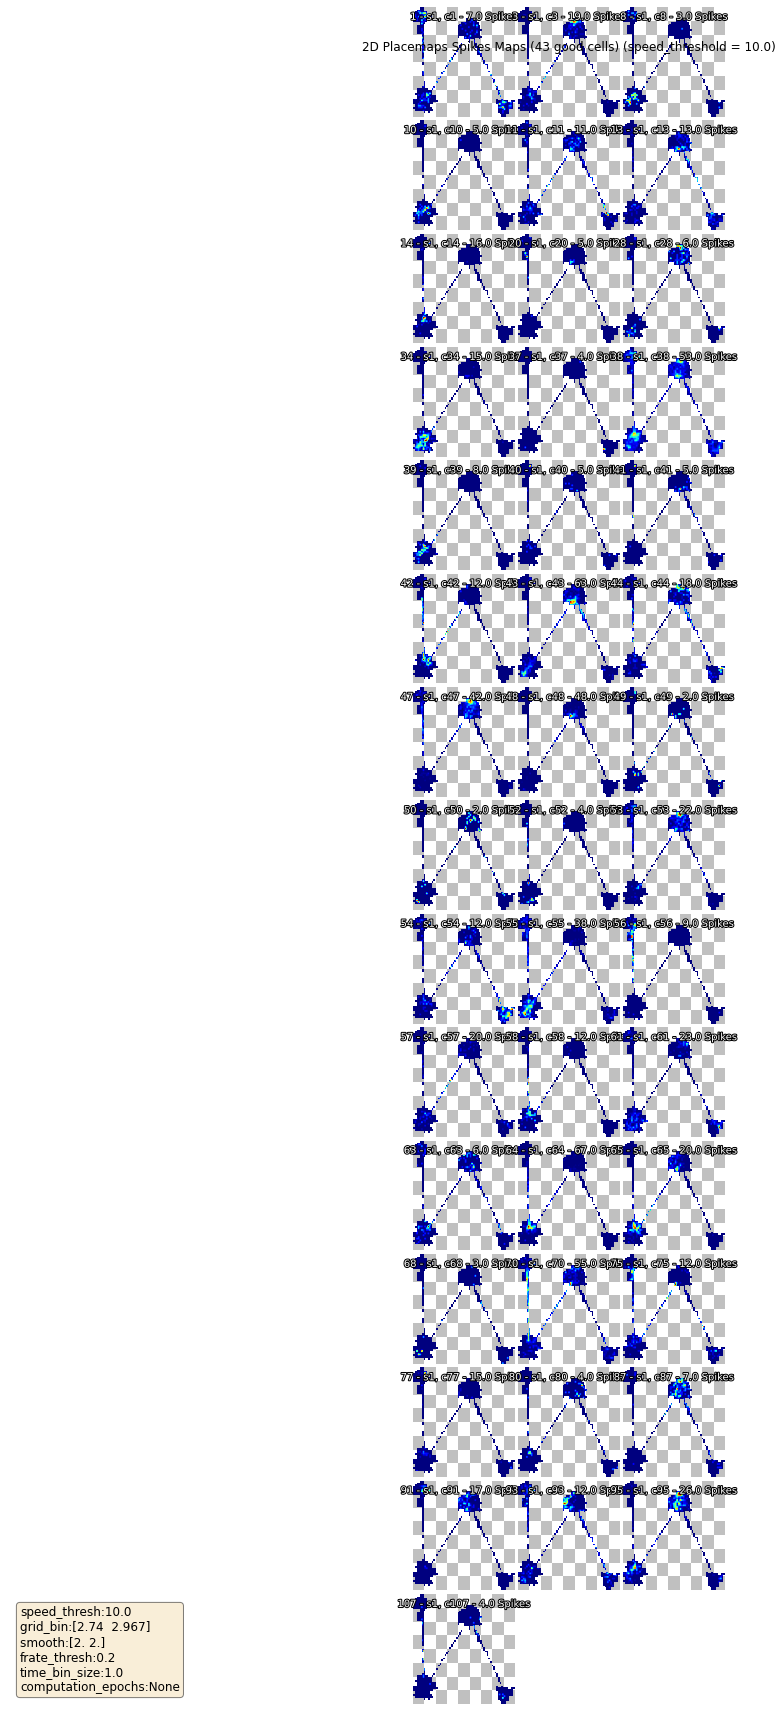

In [17]:
fig_man.reshow_figure(extant_figs_dict[10])

### Utility:

In [ ]:
# Reload display functions:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.registered_display_function_names # ['_display_1d_placefield_validations', '_display_2d_placefield_result_plot_ratemaps_2D', '_display_2d_placefield_result_plot_raw', '_display_normal', '_display_placemaps_pyqtplot_2D', '_display_decoder_result', '_display_plot_most_likely_position_comparisons', '_display_two_step_decoder_prediction_error_2D', '_display_two_step_decoder_prediction_error_animated_2D', '_display_spike_rasters_pyqtplot_2D', '_display_spike_rasters_pyqtplot_3D', '_display_spike_rasters_pyqtplot_3D_with_2D_controls', '_display_spike_rasters_vedo_3D', '_display_spike_rasters_vedo_3D_with_2D_controls', '_display_spike_rasters_window', '_display_speed_vs_PFoverlapDensity_plots', '_display_3d_image_plotter', '_display_3d_interactive_custom_data_explorer', '_display_3d_interactive_spike_and_behavior_browser', '_display_3d_interactive_tuning_curves_plotter']
print(curr_active_pipeline.registered_display_function_names)

In [ ]:
## Test getting figure save paths:
_test_fig_path = curr_active_config.plotting_config.get_figure_save_path('test')
print(f'_test_fig_path: {_test_fig_path}\n\t exists? {_test_fig_path.exists()}')

In [ ]:
%matplotlib --list 
# Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

In [ ]:
%matplotlib qt
## NOTE THAT ONCE THIS IS SET TO qt, it cannot be undone!

## Old Individual Plotting Functions:

### 🔜👁️‍🗨️ Plots for each maze:
🔜 NEXT STEP: TODO: 2022-08-10 - Got the ratemaps plotting working for all filters and those combined into a single window (with items docked) using `_build_docked_pf_2D_figures_widget`. Now need to add more plots, like the `DecoderPlotSelectorWidget`

In [21]:
""" Recreates code such as:
filter_name = 'maze1'
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config) 

For all filters
"""
import matplotlib as mpl

# @capture_new_figures_decorator
def _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name):
    active_filter_pf_2D_figures = {}
    active_filter_pf_2D_figures['SPIKES_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config)[0]
    active_filter_pf_2D_figures['TUNING_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config)[0]
    return active_filter_pf_2D_figures

active_pf_2D_figures = {}
## Plots for each maze programmatically:

_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars

for i, filter_name in enumerate(curr_active_pipeline.active_config_names):
    active_pf_2D_figures[filter_name] = _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name=filter_name)
    # curr_display_function_name = '_display_normal'
    # built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
    # with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    #     # fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk)
    #     fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, **figure_format_config)
    #     plots = [fig0, *figList1]
    #     for a_fig in plots:
    #         pdf.savefig(a_fig)

    
mpl.rcParams = _bak_rcParams # restore previous rcParams

    
active_pf_2D_figures
# {'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
#   'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
#  'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
#   'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

In [22]:
from pyphoplacecellanalysis.GUI.Qt.DecoderPlotSelectorControls.DecoderPlotSelectorWidget import DecoderPlotSelectorWidget

widget = DecoderPlotSelectorWidget()
widget.show()

In [23]:
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'

curr_fig = widget.resultplot_figureCanvas.figure
curr_fig.clear()
widget.ax.set_title(f'debug_two_step: {plotted_variable_name}')

## Get value:
""" captures active_one_step_decoder, active_two_step_decoder """
override_variable_value = None
if override_variable_value is None:
    try:
        variable_value = active_two_step_decoder[widget.variable_name]
    except (TypeError, KeyError):
        # fallback to the one_step_decoder
        variable_value = getattr(active_one_step_decoder, widget.variable_name, None)
else:
    # if override_variable_value is set, ignore the input info and use it.
    variable_value = override_variable_value

num_frames = np.shape(variable_value)[-1]
debug_print = True
if debug_print:
    print(f'_temp_debug_two_step_plots_animated_imshow: variable_name="{widget.variable_name}", np.shape: {np.shape(variable_value)}, num_frames: {num_frames}')

# widget.ui.imv.setImage(variable_value) # despite the name, 'xvals' actually refers to assigning each frame a time value
widget.ui.imv.setImage(variable_value.T.copy(), xvals=active_one_step_decoder.active_time_window_centers, autoLevels=True, autoHistogramRange=True, autoRange=True) # despite the name, 'xvals' actually refers to assigning each frame a time value
cmap = pg.colormap.get('jet','matplotlib') # prepare a linear color map
widget.ui.imv.setColorMap(cmap)

AttributeError: 'DecoderPlotSelectorWidget' object has no attribute 'resultplot_figureCanvas'

In [21]:
# fig.canvas.toolbar_visible = False
# fig.canvas.header_visible = False
# fig.canvas.footer_visible = False

{'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
  'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
 'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
  'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

In [ ]:
def _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, debug_print=False):
    """ Combines the active_pf_2D individual figures into a single widget, with each item being docked and modifiable.
    
    if should_nest_figures_on_filter is True, the figures are docked in a nested dockarea for each filter (e.g. ['maze1', 'maze2']. Otherwise they are returned flat.
        
    Unique to nested:
        all_nested_dock_area_widgets = {}
        all_nested_dock_area_widget_display_items = {}


    Usage:
    
        def _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name):
            active_filter_pf_2D_figures = {}
            active_filter_pf_2D_figures['SPIKES_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config)[0]
            active_filter_pf_2D_figures['TUNING_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config)[0]
            return active_filter_pf_2D_figures

        active_pf_2D_figures = {}
        ## Plots for each maze programmatically:
        for i, filter_name in enumerate(curr_active_pipeline.active_config_names):
            active_pf_2D_figures[filter_name] = _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name=filter_name)

        active_pf_2D_figures
        # {'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
        #   'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
        #  'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
        #   'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

        win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, debug_print=False)

    """
    min_width = 500
    min_height = 500
    win, app = DockAreaWrapper._build_default_dockAreaWindow(title='active_pf_2D_figures', defer_show=False)

    all_dock_display_items = {}
    all_item_widths_list = []
    all_item_heights_list = []

    if should_nest_figures_on_filter:
        all_nested_dock_area_widgets = {}
        all_nested_dock_area_widget_display_items = {}

        _last_dock_outer_nested_item = None
        for filter_name, a_figures_dict in active_pf_2D_figures.items():
            # For each filter, create a new NestedDockAreaWidget
            all_nested_dock_area_widgets[filter_name] = NestedDockAreaWidget()
            # Once done with a given filter, add its nested dockarea widget to the window
            if _last_dock_outer_nested_item is not None:
                #NOTE: to stack two dock widgets on top of each other, do area.moveDock(d6, 'above', d4)   ## move d6 to stack on top of d4
                dockAddLocationOpts = ['above', _last_dock_outer_nested_item] # position relative to the _last_dock_outer_nested_item for this figure
            else:
                dockAddLocationOpts = ['bottom'] #no previous dock for this filter, so use absolute positioning
            nested_out_widget_key = f'Nested Outer Widget: {filter_name}'
            if debug_print:
                print(f'nested_out_widget_key: {nested_out_widget_key}')
            _, dDisplayItem = win.add_display_dock(nested_out_widget_key, dockSize=(min_width, min_height), dockIsClosable=False, widget=all_nested_dock_area_widgets[filter_name], dockAddLocationOpts=dockAddLocationOpts)
            all_nested_dock_area_widget_display_items[filter_name] = dDisplayItem
            _last_dock_outer_nested_item = dDisplayItem

            ## Add the sub-items for this filter:
            _last_dock_item = None
            for a_figure_name, a_figure in a_figures_dict.items():
                # individual figures
                figure_key = f'{filter_name}_{a_figure_name}'
                if debug_print:
                    print(f'figure_key: {figure_key}')
                fig_window = a_figure.canvas.window()
                fig_geom = fig_window.window().geometry() # get the QTCore PyRect object
                fig_x, fig_y, fig_width, fig_height = fig_geom.getRect() # Note: dx & dy refer to width and height
                all_item_widths_list.append(fig_width)
                all_item_heights_list.append(fig_height)

                # Add the dock and keep the display item:
                if _last_dock_item is not None:
                    dockAddLocationOpts = ['above', _last_dock_item] # position relative to the _last_dock_item for this figure
                else:
                    dockAddLocationOpts = ['bottom'] #no previous dock for this filter, so use absolute positioning
                _, dDisplayItem = all_nested_dock_area_widgets[filter_name].add_display_dock(figure_key, dockSize=(fig_width, fig_height), dockIsClosable=False, widget=fig_window, dockAddLocationOpts=dockAddLocationOpts)
                dDisplayItem.setOrientation('horizontal') # want orientation of outer dockarea to be opposite of that of the inner one. # 'auto', 'horizontal', or 'vertical'.
                all_dock_display_items[figure_key] = dDisplayItem
                _last_dock_item = dDisplayItem

    else:
        ## Flat (non-nested)
        all_nested_dock_area_widgets = None
        all_nested_dock_area_widget_display_items = None
        
        for filter_name, a_figures_dict in active_pf_2D_figures.items():
            _last_dock_item = None
            for a_figure_name, a_figure in a_figures_dict.items():
                # individual figures
                figure_key = f'{filter_name}_{a_figure_name}'
                if debug_print:
                    print(f'figure_key: {figure_key}')
                fig_window = a_figure.canvas.window()
                fig_geom = fig_window.window().geometry() # get the QTCore PyRect object
                fig_x, fig_y, fig_width, fig_height = fig_geom.getRect() # Note: dx & dy refer to width and height
                all_item_widths_list.append(fig_width)
                all_item_heights_list.append(fig_height)
                
                # Add the dock and keep the display item:
                if _last_dock_item is not None:
                    #NOTE: to stack two dock widgets on top of each other, do area.moveDock(d6, 'above', d4)   ## move d6 to stack on top of d4
                    dockAddLocationOpts = ['above', _last_dock_item] # position relative to the _last_dock_item for this figure
                else:
                    dockAddLocationOpts = ['bottom'] #no previous dock for this filter, so use absolute positioning
                _, dDisplayItem = win.add_display_dock(figure_key, dockSize=(fig_width, fig_height), dockIsClosable=False, widget=fig_window, dockAddLocationOpts=dockAddLocationOpts)
                all_dock_display_items[figure_key] = dDisplayItem

                _last_dock_item = dDisplayItem

        

    # setOrientation('horizontal') # want orientation of outer dockarea to be opposite of that of the inner one. # 'auto', 'horizontal', or 'vertical'.

    # Resize window to largest figure size:
    all_item_widths_list = np.array(all_item_widths_list)
    all_item_heights_list = np.array(all_item_heights_list)
    max_width = np.max(all_item_widths_list)
    max_height = np.max(all_item_heights_list)
    win.resize(max_width, max_height)
    
    return win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items
    
    
win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, debug_print=False)

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.DecoderPlotSelectorControls.DecoderPlotSelectorWidget import DecoderPlotSelectorWidget

widget = DecoderPlotSelectorWidget()
widget.show()

## Systematic Display Function Testing

### Matplotlib-based plots:

In [ ]:
%%capture
#The above hides the output in JupyterLab Notebooks, must be first line in the cell to hide the output of
curr_display_function_name = '_display_1d_placefield_validations'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    # plt.ioff() # disable displaying the plots inline in the Jupyter-lab notebook. NOTE: does not work in Jupyter-Lab, figures still show
    plots = curr_active_pipeline.display(curr_display_function_name, active_config_name) # works, but generates a TON of plots!
    # plt.ion()
    for fig_idx, a_fig in enumerate(plots):
        # print(f'saving fig: {fig_idx+1}/{len(plots)}')
        pdf.savefig(a_fig)
        # pdf.savefig(a_fig, transparent=True)
    # When no figure is specified the current figure is saved
    # pdf.savefig()

In [ ]:
%%capture
curr_display_function_name = '_display_2d_placefield_result_plot_raw'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    a_fig = curr_active_pipeline.display(curr_display_function_name, filter_name)
    pdf.savefig(a_fig)

# Issue with unexpected kwargs passed to plots. Solve generally.
# TypeError: plot_raw() got an unexpected keyword argument 'enable_saving_to_disk'

In [ ]:
# %%capture
curr_display_function_name = '_display_normal'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    # fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk)
    fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, **figure_format_config)
    plots = [fig0, *figList1]
    for a_fig in plots:
        pdf.savefig(a_fig)

In [ ]:
curr_active_pipeline.filtered_session_names

In [ ]:
curr_display_function_name = '_display_2d_placefield_result_plot_ratemaps_2D'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
out_fig_list = []
figure_format_config['enable_saving_to_disk'] = False # don't use the in-built figure export/saving to disk functionality as we want to wrap the output figure with the Pdf saving, not write to a .png
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:    
    for filter_name in curr_active_pipeline.filtered_session_names:
        print(f'filter_name: {filter_name}')
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config)) # works!
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config))
        for a_fig in out_fig_list:
            pdf.savefig(a_fig)

In [ ]:
%%capture
curr_display_function_name = '_display_decoder_result'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
    print(plots)
    # pdf.savefig(a_fig)

### PyQtGraph-based plots:

#### Decoder Plots:

In [ ]:
curr_display_function_name = '_display_two_step_decoder_prediction_error_2D'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
out_fig_list = []
figure_format_config['enable_saving_to_disk'] = False # don't use the in-built figure export/saving to disk functionality as we want to wrap the output figure with the Pdf saving, not write to a .png
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:    
    for filter_name in curr_active_pipeline.filtered_session_names:
        print(f'filter_name: {filter_name}')
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config)) # works!
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config))
        for a_fig in out_fig_list:
            pdf.savefig(a_fig)

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_animated_2D', active_config_name, variable_name='p_x_given_n')

In [24]:
## This plot looks phenominal, and the slider works!
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev') # this one doesn't work!

In [ ]:
# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

active_one_step_decoder # BayesianPlacemapPositionDecoder
active_two_step_decoder


## SAVE OUT THE RESULTS of the decoder:

In [ ]:
active_one_step_decoder

In [ ]:
active_two_step_decoder

In [ ]:
active_one_step_decoder.active_time_window_centers.shape

In [ ]:
active_one_step_decoder.flat_position_size

### 🔜 2022-08-10 👁️‍🗨️ NOW: Plot animal positions on the computed posteriors:
The process of plotting the animal position on the decoder plot needs to be refined. Currently it works by re-implementing 

🔜 NEXT STEP: TODO: Make a "Datasource" like approach perhaps to provide the actual animal position at each point in time?
🐞🔜 BUG TODO: Noticed that for Bapun Day5 data, it looks like the current position point is being plotted incorrectly (it doesn't even move across the space much)

In [28]:
## Get the current positions at each of the time_window_centers:
# active_resampled_measured_positions
time_binned_pos_df = active_computed_data.extended_stats.time_binned_position_df
active_resampled_pos_df = time_binned_pos_df  # 1717 rows × 16 columns
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
# np.shape(active_resampled_measured_positions) # (1911, 2)
active_one_step_decoder.active_time_window_centers.shape # (1911,)

# Note this has 2900 rows × 24 columns and active_one_step_decoder.active_time_window_centers.shape is (2892,) for some reason. Shouldn't they be the same?

In [28]:
# active_one_step_decoder.active_time_window_centers

In [35]:
# np.array(active_two_step_decoder.flat_all_x).shape # (3969, 2)

(3969, 2)

In [ ]:
# active_resampled_pos_df
sub_df = pd.DataFrame({'t': active_one_step_decoder.active_time_window_centers, 'x':active_resampled_pos_df.x.to_numpy(), 'y':active_resampled_pos_df.x.to_numpy()})
sub_df

In [40]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

## Copied from DecoderPredictionError.py to modify with adding nearest animal position at each timestep:
def _temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name='p_x_given_n_and_x_prev', override_variable_value=None, update_callback_function=None):
    """Matplotlib-based imshow plot with interactive slider for displaying two-step bayesian decoding results

    ## Added _update_measured_animal_position_point(...)
    DEPENDS ON active_computed_data.extended_stats.time_binned_position_df
    
    
    Args:
        active_one_step_decoder ([type]): [description]
        active_two_step_decoder ([type]): [description]
        variable_name (str, optional): [description]. Defaults to 'p_x_given_n_and_x_prev'.
        override_variable_value ([type], optional): [description]. Defaults to None.
        update_callback_function ([type], optional): [description]. Defaults to None.
    """
    if override_variable_value is None:
        try:
            variable_value = active_two_step_decoder[variable_name]
        except (TypeError, KeyError):
            # fallback to the one_step_decoder
            variable_value = getattr(active_one_step_decoder, variable_name, None)
    else:
        # if override_variable_value is set, ignore the input info and use it.
        variable_value = override_variable_value

    num_frames = np.shape(variable_value)[-1]
    debug_print = False
    if debug_print:
        print(f'_temp_debug_two_step_plots_animated_imshow: variable_name="{variable_name}", np.shape: {np.shape(variable_value)}, num_frames: {num_frames}')

    fig, ax = plt.subplots(ncols=1, nrows=1, num=f'debug_two_step_animated: variable_name={variable_name}', figsize=(15,15), clear=True, constrained_layout=False)
    plt.subplots_adjust(left=0.25, bottom=0.25)

    frame = 0
    
    # Get extents:    
    xmin, xmax, ymin, ymax = (active_one_step_decoder.xbin[0], active_one_step_decoder.xbin[-1], active_one_step_decoder.ybin[0], active_one_step_decoder.ybin[-1])
    x_first_extent = (xmin, xmax, ymin, ymax) # traditional order of the extant axes
    active_extent = x_first_extent # for 'x == horizontal orientation'
    # active_extent = y_first_extent # for 'x == vertical orientation'

    main_plot_kwargs = {
        'origin': 'lower',
        'cmap': 'turbo',
        'extent': active_extent,
        # 'aspect':'auto',
    }

    curr_val = variable_value[:,:,frame] # untranslated output:
    curr_val = np.swapaxes(curr_val, 0, 1) # x_horizontal_matrix: swap the first two axes while leaving the last intact. Returns a view into the matrix so it doesn't modify the value
    
    im_out = ax.imshow(curr_val, **main_plot_kwargs)
    
    ## Setup Auxillary Plots:
    active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns
    active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
    measured_point = np.squeeze(active_resampled_measured_positions[frame,:])
    ## decided on using scatter
    # measured_positions_scatter = ax.scatter(measured_point[0], measured_point[1], color='white') # PathCollection
    measured_positions_scatter, = ax.plot(measured_point[0], measured_point[1], color='white', marker='o', ls='') # PathCollection
    
    def _update_measured_animal_position_point(time_window_idx, ax=None):
        """ captures `active_resampled_measured_positions` and `measured_positions_scatter` """
        measured_point = np.squeeze(active_resampled_measured_positions[time_window_idx,:])
        ## TODO: this would need to use set_offsets(...) if we wanted to stick with scatter plot.
        measured_positions_scatter.set_xdata(measured_point[0])
        measured_positions_scatter.set_ydata(measured_point[1])
    
    # for 'x == horizontal orientation':
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # ax.axis("off")
    plt.title(f'debug_two_step: {variable_name}')

    axcolor = 'lightgoldenrodyellow'
    axframe = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    sframe = Slider(axframe, 'Frame', 0, num_frames-1, valinit=2, valfmt='%d') # MATPLOTLIB Slider

    def update(val):
        new_frame = int(np.around(sframe.val))
        # print(f'new_frame: {new_frame}')
        curr_val = variable_value[:,:,new_frame] # untranslated output:
        curr_val = np.swapaxes(curr_val, 0, 1) # x_horizontal_matrix: swap the first two axes while leaving the last intact. Returns a view into the matrix so it doesn't modify the value
        im_out.set_data(curr_val)
        # ax.relim()
        # ax.autoscale_view()
        _update_measured_animal_position_point(new_frame, ax=ax)
        
        if update_callback_function is not None:
            update_callback_function(new_frame, ax=ax)
        plt.draw()

    sframe.on_changed(update)
    plt.draw()
    # plt.show()
    

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()


# active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns

# Simple plot type 1:
# plotted_variable_name = kwargs.get('variable_name', 'p_x_given_n') # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, variable_name=plotted_variable_name) # Works

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
## Works, displays my velocity/density result for both 2D and 1D:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
plots

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
out_plots = curr_active_pipeline.display(curr_display_function_name, filter_name)    
out_plots[1].show()

In [ ]:
## KNOWN BAD, locks up, do not execute:
curr_display_function_name = 'display_firing_rate_trends'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)

In [ ]:
# a_plot = plots[0] # PlotWidget 
# a_plot_item = a_plot.plotItem # PlotItem
# a_plot.scene() # GraphicsScene
export_pyqtgraph_plot(plots[0])

### 3D (PyVista/Vedo/etc)-based plots:

In [ ]:
curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name) # this works now!

In [ ]:
display_dict = curr_active_pipeline.display('_display_3d_interactive_custom_data_explorer', active_config_name) # does not work, missing color info?
iplapsDataExplorer = display_dict['iplapsDataExplorer']
# plotter is available at
p = display_dict['plotter']
iplapsDataExplorer

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', 'maze') # works!


# Testing: Position Decoding:

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

## PyQtPlot Exploration

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

### Custom DataTree Widget that displays a nested hierarchy of data:


In [ ]:
# d = {
#     'active_sess_config':curr_active_pipeline.active_sess_config.__dict__,
#     'active_configs':curr_active_pipeline.active_configs,
#     'active_session_computation_configs':active_session_computation_configs[0].__dict__
# }
d = {
    "computed_data": curr_active_pipeline.computation_results['maze1'].computed_data,
    # "computation_results['maze1']'": curr_active_pipeline.computation_results['maze1'],
}
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
tree, app = plot_dataTreeWidget(data=d, title='PhoOutputDataTreeApp')
tree.show()

In [ ]:
# tree.show()
tree = None
app = None

In [ ]:
tree.resize(1920, 1200) # pyqtgraph.widgets.DataTreeWidget.DataTreeWidget
tree.resizeColumnToContents(2)
# setFormat(format, column=None)
# tree.resizeColumnToContents(1)
# tree.expandToDepth
print(tree.dumpObjectInfo())
# tree.expandAll()
# tree.nodes # a dict

# tree.hideColumn(2) # hides the value column
# print(tree.children()[0].dumpObjectInfo())
# # tree.children()[1] # <PyQt5.QtWidgets.QStyledItemDelegate at 0x197b467fca0>
# # tree.children()[2]
# # tree.children()[3].dumpObjectTree() # QAbstractItemModel
# print(tree.children()[3].dumpObjectInfo())
# # listAllItems()
# # tree.itemFromIndex(0)
# # tree.findChild()
# # listAllItems()
# tree.collapseAll()

In [ ]:
# InteractivePlaceCellConfig
from pprint import pprint
pprint(curr_active_pipeline.active_configs['maze1'].__dict__)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Params.pyqtplot_ParamTreeWidget import plot_paramTreeWidget
param_tree, param_tree_app = plot_paramTreeWidget(title='PhoMainParamTreeApp')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

print_keys_if_possible('active_pf_overlap_results', active_pf_overlap_results)

In [ ]:
# active_placefield_overlap
# total_pairwise_overlaps
# all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

# Pho Scratch Workspace

## Working firing rates fresh from spikes_df

In [ ]:
print(f'time_bin_size_seconds: {time_bin_size_seconds}')

active_filter_name = 'maze1'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

In [ ]:
active_filter_name = 'maze2'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

In [ ]:
active_filter_name = 'maze'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

KDiba Data:
time_bin_size_seconds: 0.5
active_filter_name: maze1
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 26 38 14 22 24 10 22 40 24 24 26 18 48 40 14 38 20 48 44]
active_filter_name: maze2
	max_spike_rates: [6 10 8 18 30 6 18 14 12 14 24 4 10 48 24 12 6 16 16 16 32 26 14 10 14 10 6 12 30 12 4 16 22 18 20 4 10 6 36 24]
active_filter_name: maze
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 32 38 14 22 24 10 22 40 24 24 26 20 48 40 14 38 20 48 44]


In [ ]:
unit_specific_binned_spike_counts

time_bin_size_seconds: 0.25
	max_spike_rates: [36 36 36 36 60 20 40 48 40 48 40 44 100 92 36 32 80 52 32 48 52 36 68 24 44 36 16 32 44 36 48 36 36 52 48 28 40 24 72 52]

time_bin_size_seconds: 0.5
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 26 38 14 22 24 10 22 40 24 24 26 18 48 40 14 38 20 48 44]
    
time_bin_size_seconds: 1.0
	max_spike_rates: [16 21 18 17 22 12 22 18 16 25 25 25 65 48 19 20 30 32 20 30 24 21 26 8 11 17 5 14 30 14 17 25 11 30 26 11 27 10 37 38]

time_bin_size_seconds: 10.0
	max_spike_rates: # array([3.6, 5.6, 2.5, 6.2, 7.2, 2.3, 7.4, 4.8, 3.3, 5.2, 15.3, 4.3, 21.8, 12.4, 7.5, 5.4, 4.8, 4.3, 4.9, 6, 9.5, 7.7, 2.6, 2.3, 4.1, 2.8, 1.3, 5.1, 11.5, 5.1, 3.2, 9.4, 3.7, 8.8, 9.7, 2.9, 5.2, 1.7, 12, 5.9])
    # Filtered pf only spikes: array([2.6, 3.9, 2, 3.6, 3.8, 1.3, 3.7, 1.8, 2, 2.6, 2.3, 1.4, 5.7, 6.1, 3.1, 2.7, 4.9, 3.3, 3.9, 3.3, 5.9, 2.7, 2.6, 1.4, 1.4, 2.9, 1, 2.3, 5.4, 2.4, 0.9, 3.6, 1.4, 4.5, 3.4, 0.8, 2.8, 1.1, 2.6, 4.9])

In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
active_firing_rate_trends.keys() # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

In [ ]:
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df

## New 2022-07-31 Firing Rate Across-Session Printing with explicit time binning

In [ ]:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.print_helpers import document_active_variables, print_keys_if_possible
# CodeConversion

In [ ]:
# print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends, additional_excluded_item_classes=['pandas.core.series.Series'])
print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends)

In [ ]:
### Reformat long class strings to suscint class names:
import re ## required for strip_type_str_to_classname(...)

def _format_curr_value(depth_string, curr_key, type_string, type_name):
    return f"{depth_string}['{curr_key}']: {type_name}"
        
print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends, custom_item_formatter=_format_curr_value)

In [ ]:
document_active_variables(active_firing_rate_trends, enable_print=True)

In [ ]:
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)

In [ ]:
active_firing_rate_trends.all_session_spikes.

In [ ]:
def _print_active_firing_rate_trends_result_overview(active_firing_rate_trends):
    def _print_single_result(a_trends_set):
        # a_trends_set['time_window_edges']
        # a_trends_set['time_window_edges_binning_info']
        binned_rates = a_trends_set['time_binned_unit_specific_binned_spike_rate']
        mins = a_trends_set['min_spike_rates'].to_numpy()
        means = binned_rates.mean().to_numpy()
        medians = a_trends_set['median_spike_rates'].to_numpy()
        maxs = a_trends_set['max_spike_rates'].to_numpy()
        # print(f"\t\tmins: {mins}") # all zero, which is reasonable I suppose
        print(f"\t\tmeans: {means}") # non-zero, which is good.
        # print(f"\t\tmedians: {medians}") # also all zero, which doesn't seem super reasonable
        print(f"\t\tmaxs: {maxs}")
    print(f"time_bin_size_seconds: {active_firing_rate_trends['time_bin_size_seconds']}")
    print(f"\tall_session_spikes: ")
    _print_single_result(active_firing_rate_trends['all_session_spikes'])
    print(f"\tpf_included_spikes_only: ")
    _print_single_result(active_firing_rate_trends['pf_included_spikes_only'])
    

_print_active_firing_rate_trends_result_overview(active_firing_rate_trends)

In [ ]:
computation_result_names = list(curr_active_pipeline.computation_results.keys()) # ['maze1', 'maze2']
for a_result_name, a_computation_result in curr_active_pipeline.computation_results.items():
    print(f'>> {a_result_name}') ## e.g. 'maze1'
    active_firing_rate_trends = a_computation_result.computed_data.get('firing_rate_trends', None)
    _print_active_firing_rate_trends_result_overview(active_firing_rate_trends)


# def across_epoch_computation_function(computation_results):
#     """ an example of a function that operates across all computation_results. Computed after all computations are complete. """


## Compute the firing rates in the windows corresponding to the sampling rate of the position bins, or better yet for the entire duration spent in a single position bin (splitting on bin-index changes

In [ ]:
from neuropy.utils.mixins.binning_helpers import build_df_discretized_binned_position_columns
active_pf_2D.filtered_spikes_df, (xbin, ybin), bin_info = build_df_discretized_binned_position_columns(active_pf_2D.filtered_spikes_df.copy(), bin_values=(active_pf_2D.xbin, active_pf_2D.ybin), active_computation_config=active_computation_config, force_recompute=False, debug_print=False)
bin_info['mode'] = active_pf_2D.bin_info['mode'] # get the original mode used to compute the bins
active_pf_2D.bin_info = bin_info # replace the bin_info with the updated version
# active_pf_2D.filtered_spikes_df

In [ ]:
# sess.spikes_df # no 'binned_x' column
active_pf_2D.filtered_spikes_df

In [ ]:
#### Need to compute the best-known transition times between position bins for all spikes as not to truncate the starts/ends of the bins (which would happen if doing a single cell at a time)
# active_df.binned_x
active_df['_binned_x_transitions'] = active_df['binned_x'].diff()
active_df_filtered_binned_x_transitions_only = active_df[active_df['_binned_x_transitions'] != 0] # get only the transition points (for binned_x)
active_df_filtered_binned_x_transitions_only

active_df_filtered_binned_x_transitions_only = active_df_filtered_binned_x_transitions_only[['t_rel_seconds', 'binned_x']]
# Get durations spent in the bin:
active_df_filtered_binned_x_transitions_only['bin_occupied_duration'] = active_df_filtered_binned_x_transitions_only['t_rel_seconds'].diff() # How long the animal spent in this bin before transitioning (along its axis)
active_df_filtered_binned_x_transitions_only


In [ ]:
transition_start_spike_index = active_df_filtered_binned_x_transitions_only.index
transition_end_spike_index = transition_start_spike_index - 1 # the end of each occurs at the time of the previous one

In [ ]:
#### In general, for each neuron, get the spikes that occured during each bin_occupation_event 'i' (from t_rel_seconds[i] to (t_rel_seconds[i] + bin_occupied_duration[i])) and divide by the bin_occupied_duration[i]
# This will give the bin_occupation_event's spike_rate for each neuron which we can filter on (to find the neuron's that fire > 1Hz for this bin_occupation_event)

"""
Along a given axis (x or y), an animal occupies a single bin at each time given by (binned_x or binned_y). 
When the animal changes bins and a transition occurs along a given axis, it is said to terminate the occupation of the previous bin and start the occupation of the new bin.

These (start_t, bin_occupied_duration, binned_x) tuples denote a unique event, termed a `bin_occupation_event`.

Within a given bin_occupation_event each neuron has an instantaneous bin firing rate given by: (number of spikes it fired during the event) / bin_occupied_duration

"""

## Change to simplier non-time-dependent version:

In [ ]:
# Plot from the active_simpler_pf_densities_analysis
out_app, out_win, out_imageView = pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D)

In [ ]:
# out = BinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
out = BasicBinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
# pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_pf_2D_dt.curr_firing_maps_matrix)

In [ ]:
# Compute the updated counts:
current_spike_per_unit_per_bin_counts = active_df.value_counts(subset=['fragile_linear_neuron_IDX', 'binned_x', 'binned_y'], normalize=False, sort=False, ascending=True, dropna=True) # dropna=True
current_spike_per_unit_per_bin_counts # pandas.core.series.Series

In [ ]:
type(current_spike_per_unit_per_bin_counts) # pandas.core.series.Series
# current_spike_per_unit_per_bin_counts[0]

pd.DataFrame(current_spike_per_unit_per_bin_counts)

In [ ]:
debug_print = True
for (fragile_linear_neuron_IDX, xbin_label, ybin_label), count in current_spike_per_unit_per_bin_counts.iteritems():
    if debug_print:
        print(f'fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, xbin_label: {xbin_label}, ybin_label: {ybin_label}, count: {count}')
    try:
        last_firing_maps_matrix[fragile_linear_neuron_IDX, xbin_label-1, ybin_label-1] += count
    except IndexError as e:
        print(f'e: {e}\n active_current_spike_df: {np.shape(active_current_spike_df)}, current_spike_per_unit_per_bin_counts: {np.shape(current_spike_per_unit_per_bin_counts)}\n last_firing_maps_matrix: {np.shape(last_firing_maps_matrix)}\n count: {count}')
        print(f' last_firing_maps_matrix[fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, (xbin_label-1): {xbin_label-1}, (ybin_label-1): {ybin_label-1}] += count: {count}')
        raise e
        

In [ ]:
## Now want it arranged by-bin instead of by-neuron:


## LATER: Also need to collapse over all binned_y for each binned_x (marginalize) - I think

## Get 2D Heatmaps of Velocity and Occupancy working:
NOTE: This works great, and is the best figure for overall Eloy pf_Density/velocity analyeses.

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem

def display_all_eloy_pf_density_measures_results(active_pf_2D, active_eloy_analysis, active_simpler_pf_densities_analysis, active_peak_prominence_2d_results):
    # active_xbins = active_pf_2D.xbin
    # active_ybins = active_pf_2D.ybin
    
    # # *bin_indicies:
    # xbin_indicies = active_pf_2D.xbin_labels -1
    # ybin_indicies = active_pf_2D.ybin_labels -1
    # active_xbins = xbin_indicies
    # active_ybins = ybin_indicies
    
    # *bin_centers: these seem to work
    active_xbins = active_pf_2D.xbin_centers
    active_ybins = active_pf_2D.ybin_centers
    
    out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_xbins, active_ybins, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity')
    out.add_data(row=2, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_xbins, ybins=active_ybins, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
    out.add_data(row=3, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_xbins, ybins=active_ybins, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')
    out.add_data(row=4, col=0, matrix=active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D, xbins=active_xbins, ybins=active_ybins, name='n_neurons_meeting_firing_critiera_by_position_bins_2D', title='# neurons > 1Hz per Pos (X, Y)', variable_label='# neurons')
    # out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
    # out.add_data(row=6, col=0, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')
    out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
    out.add_data(row=6, col=0, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')

    return out
    
out_all_eloy_pf_density_fig = display_all_eloy_pf_density_measures_results(active_pf_2D, active_eloy_analysis, active_simpler_pf_densities_analysis, active_peak_prominence_2d_results)

In [ ]:
out_all_eloy_pf_density_fig.close()

## Test getting prominences with peak_prominence2d

In [ ]:
curr_display_function_name = '_display_pf_peak_prominence2d_default_quadrant_plots'
out_figs, out_axes, out_idxs = curr_active_pipeline.display(curr_display_function_name, active_config_name) 

In [ ]:
curr_display_function_name = 'plot_Prominence'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    for an_idx, a_fig in zip(active_peak_prominence_2d_results.neuron_extended_ids, out_figs):
        a_fig.suptitle(f'neuron: {an_idx.id}', fontsize=16)
        pdf.savefig(a_fig)

In [ ]:
curr_display_function_name = '_display_pf_peak_prominence2d_plots'
figure, ax = curr_active_pipeline.display(curr_display_function_name, active_config_name, neuron_id=2) 

# Quantitatively Analyzing the prominence computation results
For a single neuron:
Care about:
 - Pf Num of Peaks: expresses whether a cell responds selectively to a single location, is bi-modal, tri-modal, etc.
 - Peak Locations: (to determine the number of peaks per bin or region)
 - Peak Prominences/Relative heights
   Pf Sizes: defined by our bounding boxes
   Stability??

QuantPeakResult

In [ ]:
list(active_peak_prominence_2d_results.keys())
active_peak_prominence_2d_results.filtered_flat_peaks_df.columns # ['neuron_id', 'neuron_peak_firing_rate', 'summit_idx', 'summit_slice_idx', 'slice_level_multiplier', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_binned_x', 'peak_center_binned_y', 'peak_center_avg_speed', 'peak_nearest_directional_boundary_bins', 'peak_nearest_directional_boundary_displacements', 'peak_nearest_directional_boundary_distances', 'nearest_directional_boundary_direction_idx', 'nearest_directional_boundary_direction_distance', 'nearest_x_boundary_distance', 'nearest_y_boundary_distance']

### Test distance to boundary by computing the distance to the nearest never-occupied bin

In [ ]:
# active_peak_prominence_2d_results.filtered_flat_peaks_df
# active_eloy_analysis.avg_2D_speed_per_pos
# active_peak_prominence_2d_results.filtered_flat_peaks_df
subfiltered_peaks_df = active_peak_prominence_2d_results.filtered_flat_peaks_df[active_peak_prominence_2d_results.filtered_flat_peaks_df['summit_idx']==1].copy()
subfiltered_peaks_df

In [ ]:
# # correlated with 'summit_slice_x_width', 'summit_slice_y_width'
x_distances = subfiltered_peaks_df['nearest_x_boundary_distance'].values # find the distance to nearest wall vertically
y_distances = subfiltered_peaks_df['nearest_y_boundary_distance'].values # find the distance to nearest wall horizontally
x_widths = subfiltered_peaks_df['summit_slice_x_width'].values
y_widths = subfiltered_peaks_df['summit_slice_y_width'].values
# Convert the pf widths in cm to fractional number of bins"
x_width_num_bins = x_widths / float(active_pf_2D.bin_info['xstep'])
y_width_num_bins = y_widths / float(active_pf_2D.bin_info['ystep'])

peak_center_xy_points_pos_list = subfiltered_peaks_df[['peak_center_x', 'peak_center_y']].values
slice_center_xy_points_pos_list = subfiltered_peaks_df[['summit_slice_center_x', 'summit_slice_center_y']].values
slice_center_xy_points_pos_list.shape # (40, 2)

peak_aclu = subfiltered_peaks_df.neuron_id.values

In [ ]:
import matplotlib.pyplot as plt

## Plots for analyzing the distance from ends of maze:
fig, ax = plt.subplots(num=10, clear=True)
im = ax.scatter(x_distances, x_width_num_bins)
im2 = ax.scatter(x_distances, y_width_num_bins, c='r')
lgd = ax.legend(['x_size', 'y_size'])
ax.set_xlabel('distance from nearest x boundary [# bins]')
ax.set_ylabel('placefield width [# bins]')
fig.show()

In [ ]:
## Plots for analyzing the distance from sides of track
fig, ax = plt.subplots(num=11, clear=True)
im = ax.scatter(y_distances, x_width_num_bins)
im2 = ax.scatter(y_distances, y_width_num_bins, c='r')
lgd = ax.legend(['x_size', 'y_size'])
ax.set_xlabel('distance from nearest y boundary [# bins]')
ax.set_ylabel('placefield width [# bins]')
fig.show()

## Render a figure to display the computed distances and their relations to the widths:

### Trying to add annotations to the normal 2D MATPLOTLIB heatmaps with `annotate` command:

In [ ]:
## NEW DICT FORMAT:
# 1 point for each neuron_id:
peaks_overlay_points_data_dict = {aclu:dict(is_enabled=True, points_data=peak_center_xy_points_pos_list[aclu == peak_aclu,:], plot_opts={'markersize': 22, 'marker': '*', 'markeredgecolor': 'grey', 'linestyle': 'none', 'markerfacecolor': 'white', 'alpha': 0.85, 'label': 'peaks_overlay_points'},
                                                                             scatter_opts={'s': 22, 'c': 'white', 'alpha': 0.85, 'marker': '*', 'label': 'peaks_overlay_sc'}, plots={}) for aclu in peak_aclu} # active_pf_2D.included_neuron_IDs
slice_center_overlay_points_data_dict = {aclu:dict(is_enabled=True, points_data=slice_center_xy_points_pos_list[aclu == peak_aclu,:], plot_opts={'markersize': 20, 'marker': '^', 'markeredgecolor': 'grey', 'linestyle': 'none', 'markerfacecolor': 'white', 'alpha': 0.8, 'label': 'slice_center_overlay_points'},
                                                                             scatter_opts={'s': 20, 'c': 'white', 'alpha': 0.8, 'marker': '^', 'label': 'slice_center_overlay_sc'}, plots={}) for aclu in peak_aclu} # active_pf_2D.included_neuron_IDs

extended_overlay_points_datasource_dicts = {'peaks_overlay_points': peaks_overlay_points_data_dict, 'slice_center_overlay_points': slice_center_overlay_points_data_dict}

# filter_name = 'maze1'
figure_format_config['enable_saving_to_disk'] = False
# curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config, extended_overlay_points_datasource_dicts=extended_overlay_points_datasource_dicts)

In [ ]:
curr_display_function_name = '_display_normal'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=False, extended_overlay_points_datasource_dicts=extended_overlay_points_datasource_dicts)
    plots = [fig0, *figList1]
    for a_fig in plots:
        pdf.savefig(a_fig)

In [ ]:
fig = figList1[0]
ax_list = fig.axes

curr_neuron_IDX = 0
curr_ax = ax_list[curr_neuron_IDX]
curr_peak_center = peak_center_xy_points_pos_list[curr_neuron_IDX, :]
curr_edge_pos = 

# curr_ax_peak_center_point_annotation = curr_ax.annotate('EXAMPLETEXT', curr_peak_center)
curr_ax.annotate('', tuple(curr_peak_center), (0.4, 0.8), arrowprops={'arrowstyle':'<->'})

# curr_ax.annotate('', (0.4, 0.2), (0.4, 0.8), arrowprops={'arrowstyle':'<->'})

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem

# out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')


# # *bin_centers: these seem to work
# active_xbins = active_pf_2D.xbin_centers
# active_ybins = active_pf_2D.ybin_centers


# out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
# out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_xbins, active_ybins, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity')
# out.add_data(row=2, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_xbins, ybins=active_ybins, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

### Use Pandas' df.corr() method

In [ ]:
subset_variable_names = ['neuron_peak_firing_rate', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_avg_speed']
active_input_matrix = active_peak_prominence_2d_results.filtered_flat_peaks_df[subset_variable_names].copy()

# active_corr_matrix = active_input_matrix.corr(method='pearson') # default
active_corr_matrix = active_input_matrix.corr(method='spearman') # spearman
active_corr_matrix

In [ ]:
## Plot correlation matrix using imshow:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def _plot_df_correlation_matrix(active_corr_matrix):
    """
    Usage:
        subset_variable_names = ['neuron_peak_firing_rate', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_avg_speed']
        active_input_matrix = active_peak_prominence_2d_results.filtered_flat_peaks_df[subset_variable_names].copy()

        # active_corr_matrix = active_input_matrix.corr(method='pearson') # default
        active_corr_matrix = active_input_matrix.corr(method='spearman') # spearman
        fig, ax, im = _plot_df_correlation_matrix(active_corr_matrix)
        
    """
    corr_matrix = active_corr_matrix.copy().round(decimals=2)
    matrix_column_names = corr_matrix.columns
    n_columns = len(matrix_column_names)

    fig, ax = plt.subplots()
    im = ax.imshow(corr_matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=tuple(np.arange(n_columns)), ticklabels=tuple(matrix_column_names))
    ax.yaxis.set(ticks=tuple(np.arange(n_columns)), ticklabels=tuple(matrix_column_names))
    plt.xticks(rotation=45, ha='right')
    # ax.set_ylim(2.5, -0.5)
    ## Add Labels:
    for i in range(n_columns):
        for j in range(n_columns):
            ax.text(j, i, corr_matrix.iat[i, j], ha='center', va='center', color='r')
            # ax.text(j, i, corr_matrix[i, j], ha='center', va='center', color='r')

    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()
    return fig, ax, im

fig, ax, im = _plot_df_correlation_matrix(active_corr_matrix)

In [ ]:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, CodeConversion, inspect_callable_arguments

# CodeConversion.get_arguments_as_optional_dict(size=3, mode='constant') # , **({'size': 3, 'mode': 'constant'} | kwargs)
# CodeConversion.get_arguments_as_optional_dict(sigma=3) # , **({'sigma': 3} | kwargs)
# CodeConversion.get_arguments_as_optional_dict(slice_level_multiplier=0.5, minimum_included_peak_height=0.2) # , **({'slice_level_multiplier': 0.5, 'minimum_included_peak_height': 0.2} | kwargs)

# # _perform_pf_find_ratemap_peaks_peak_prominence2d_computation(...): optional arguments
# {'summits_analysis':{'slice_level_multiplier': 0.5, 'minimum_included_peak_height': 0.2},
#  'uniform_filter':{'size': 3, 'mode': 'constant'},
#  'gaussian_filter':{'sigma': 3}}


pf_summits_analysis_peak_counts_results = active_peak_prominence_2d_results.peak_counts

In [ ]:
## Renders the active_peak_prominence_2d_results.peak_counts with varying methods of blurring:
pf_summits_analysis_peak_counts_results = active_peak_prominence_2d_results.peak_counts
out_peak_counts_fig = BasicBinnedImageRenderingWindow(pf_summits_analysis_peak_counts_results.raw, active_pf_2D.xbin_labels, active_pf_2D.ybin_labels, name='pf_peak_counts_map', title="# pf peaks per Pos (X, Y)", variable_label='# pf peaks')
out_peak_counts_fig.add_data(row=5, col=0, matrix=pf_summits_analysis_peak_counts_results.uniform_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred', title='blurred # pf peaks per Pos (X, Y)', variable_label='blurred # pf peaks')
out_peak_counts_fig.add_data(row=6, col=0, matrix=pf_summits_analysis_peak_counts_results.gaussian_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')

In [ ]:
## Add to existing plot:
out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
out.add_data(row=6, col=0, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')

In [ ]:
## TODO: now that I have an filtered_summits_analysis_df['peak_center_avg_speed'] associated with each peak, can now look at things like:
# size vs. avg_speed
# ??DENSITY?? vs. avg speed

# Find non-NAN speeds only:
good_indicies = np.isfinite(active_eloy_analysis.avg_2D_speed_per_pos)
masked_avg_2D_speed_per_pos = np.ma.array(active_eloy_analysis.avg_2D_speed_per_pos, mask=~good_indicies)
masked_peak_counts_gaussian_blurred = np.ma.array(active_peak_prominence_2d_results.peak_counts.gaussian_blurred, mask=~good_indicies)

## Compute correlation between pf_peak_counts_map_blurred_gaussian and 
from scipy import signal
# METHOD 0: Fill in the missing values with the mean:
# filled_avg_2D_speed_per_pos = masked_avg_2D_speed_per_pos.filled(masked_avg_2D_speed_per_pos.mean())
# filled_peak_counts_gaussian_blurred = masked_peak_counts_gaussian_blurred.filled(masked_peak_counts_gaussian_blurred.mean())
# METHOD 1: Fill in the missing values with zeros:
filled_avg_2D_speed_per_pos = masked_avg_2D_speed_per_pos.filled(0.0)
filled_peak_counts_gaussian_blurred = masked_peak_counts_gaussian_blurred.filled(0.0)

## Compute the correlation
corr = signal.correlate2d(filled_peak_counts_gaussian_blurred, filled_avg_2D_speed_per_pos, boundary='symm', mode='same')
## Show the corr plot in the open out_peak_counts_fig 
out.add_data(row=7, col=0, matrix=corr, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='correlate2d(gauss_peak_counts, avg_2d_speed)', title='correlate2d(gauss_peak_counts, avg_2d_speed) per Pos (X, Y)', variable_label='corr')

In [ ]:
## Flatten all valid indicies of each variable to a matrix, to compute the relation between the variables as if each position was a separate independent sample
def compute_flattened_finite_variable_vectors(xbins, ybins, avg_2D_speed_per_pos, matrix):
    """ Flatten all valid indicies of each variable to a matrix, to compute the relation between the variables as if each position was a separate independent sample 
    Inputs:
        avg_2D_speed_per_pos: TODO: refactor, basically just the matrix with NaNs in it
        matrix: a matrix of the same size as avg_2D_speed_per_pos with either no NaNs or at worst NaNs in the same positions as avg_2D_speed_per_pos
    
    Usage:
        
good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred = compute_flattened_finite_variable_vectors(xbins=active_peak_prominence_2d_results.xx, ybins=active_peak_prominence_2d_results.yy, avg_2D_speed_per_pos=active_eloy_analysis.avg_2D_speed_per_pos, matrix=pf_summits_analysis_peak_counts_results.gaussian_blurred)
    """
    # Find non-NAN speeds only:
    good_indicies = np.isfinite(avg_2D_speed_per_pos)

    flat_valid_avg_2D_speed_per_pos = avg_2D_speed_per_pos[good_indicies].flatten()
    flat_valid_peak_counts_gaussian_blurred = matrix[good_indicies].flatten()

    # Build the mesh of flattened x and y positions for each bin
    n_xbins = np.shape(avg_2D_speed_per_pos)[0] 
    n_ybins = np.shape(avg_2D_speed_per_pos)[1]
    x_pos_mat = np.repeat(np.atleast_2d(xbins), axis=0, repeats=n_ybins).T #.shape # (7, 60)
    y_pos_mat = np.repeat(np.atleast_2d(ybins).T, axis=1, repeats=n_xbins).T
    assert np.shape(x_pos_mat) == np.shape(y_pos_mat) == np.shape(avg_2D_speed_per_pos)
    flat_valid_xbin_centers = x_pos_mat[good_indicies].flatten()
    flat_valid_ybin_centers = y_pos_mat[good_indicies].flatten()
    assert np.shape(flat_valid_xbin_centers) == np.shape(flat_valid_ybin_centers) == np.shape(flat_valid_peak_counts_gaussian_blurred)
    return good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred

good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred = compute_flattened_finite_variable_vectors(xbins=active_peak_prominence_2d_results.xx, ybins=active_peak_prominence_2d_results.yy, avg_2D_speed_per_pos=active_eloy_analysis.avg_2D_speed_per_pos, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred)

In [ ]:
import scipy.stats

### Linear Correlations

In [ ]:
from scipy.stats import linregress

x = flat_valid_avg_2D_speed_per_pos.copy()
y = flat_valid_peak_counts_gaussian_blurred.copy()
result = linregress(x, y)
print(f'y = {result.slope:.6f}x + {result.intercept:.6f}')
# print(result.intercept, result.intercept_stderr)
print(f'p: {result.pvalue}')
print(f"R-squared: {result.rvalue**2:.6f}")

## Calculate 95% confidence interval on slope and intercept:
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)
print(f"slope (95%): {result.slope:.6f} +/- {ts*result.stderr:.6f}")
print(f"intercept (95%): {result.intercept:.6f}"
      f" +/- {ts*result.intercept_stderr:.6f}")

In [ ]:
## Plot linear regression outputs:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.xlabel('Velocity cm/sec')
plt.ylabel('blurred peak count')
plt.title('Linear Regressionf for animal speed vs. blurred peak count')
plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Rank Correlations

In [ ]:
x = flat_valid_avg_2D_speed_per_pos.copy()
y = flat_valid_peak_counts_gaussian_blurred.copy()
# scipy.stats.rankdata(flat_valid_avg_2D_speed_per_pos)
rho, p = scipy.stats.spearmanr(x, y)
print(f'spearman rho: {rho:.6f}, p={p:.6f}')

In [ ]:
tau, p = scipy.stats.kendalltau(x, y)
print(f'kendalltau kau: {tau:.6f}, p={p:.6f}')

## Testing Variable Viewers

In [ ]:
from pyphocorehelpers.gui.tkinter.tk_tree_view import tk_tree_view

In [ ]:
def visualise_dict(d, lvl=0):
    # go through the dictionary alphabetically 
    for k in sorted(d):
        # print the table header if we're at the beginning
        if lvl == 0 and k == sorted(d)[0]:
            print('{:<25} {:<15} {:<10}'.format('KEY','LEVEL','TYPE'))
            print('-'*79)

        indent = '  '*lvl # indent the table to visualise hierarchy
        t = str(type(d[k]))

        # print details of each entry
        print("{:<25} {:<15} {:<10}".format(indent+str(k),lvl,t))

        # if the entry is a dictionary
        if type(d[k])==dict:
            # visualise THAT dictionary with +1 indent
            visualise_dict(d[k],lvl+1)

In [ ]:
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, pprint, debug_dump_object_member_shapes

In [ ]:
# tk_tree_view(peaks[1])
# tk_tree_view(peaks)

# tk_tree_view(ipcDataExplorer.plots.to_dict())
visualise_dict(ipcDataExplorer.plots)

In [ ]:
str(type(tuningCurvePlotData[2]['pdata_currActiveNeuronTuningCurve']))

# pyvista.core.pointset.StructuredGrid

In [ ]:
# print_keys_if_possible('plots_data', ipcDataExplorer.plots_data) # RenderPlotsData
tuningCurvePlotData = ipcDataExplorer.plots_data['tuningCurvePlotData']
# - tuningCurvePlotData: <class 'indexed.IndexedOrderedDict'>
# 	- 2: <class 'dict'>
# 		- curr_active_neuron_ID: <class 'numpy.int32'>
# 		- curr_active_neuron_pf_identifier: <class 'str'>
# 		- curr_active_neuron_tuning_Curve: <class 'numpy.ndarray'> - (29, 64)
# 		- pdata_currActiveNeuronTuningCurve: <class 'pyvista.core.pointset.StructuredGrid'> - OMITTED TYPE WITH NO SHAPE
# 		- pdata_currActiveNeuronTuningCurve_Points: <class 'pyvista.core.pointset.UnstructuredGrid'> - OMITTED TYPE WITH NO SHAPE
# 		- lut: <class 'vtkmodules.vtkCommonCore.vtkLookupTable'>
        
# 'occupancyPlotData'
# tuningCurvePlotData.shape
print_keys_if_possible('tuningCurvePlotData', tuningCurvePlotData) # RenderPlotsData

In [ ]:
print_keys_if_possible('ipcDataExplorer.plots', ipcDataExplorer.plots, additional_excluded_item_classes=["<class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'>", "<class 'vtkmodules.vtkRenderingAnnotation.vtkLegendBoxActor'>"]) # RenderPlots
# pcDataExplorer.plots: <class 'pyphocorehelpers.DataStructure.general_parameter_containers.RenderPlots'>
# 	- name: <class 'str'>
# 	- occupancyPlotActor: <class 'NoneType'>
# 	- maze_bg: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 	- tuningCurvePlotActors: <class 'indexed.IndexedOrderedDict'>
# 		- 2: <class 'pyphocorehelpers.gui.PyVista.CascadingDynamicPlotsList.CascadingDynamicPlotsList'>
# 			- main: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 			- points: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
#           ...
#         - 64: <class 'pyphocorehelpers.gui.PyVista.CascadingDynamicPlotsList.CascadingDynamicPlotsList'>
# 			- main: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 			- points: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 	- tuningCurvePlotLegendActor: <class 'vtkmodules.vtkRenderingAnnotation.vtkLegendBoxActor'> - OMITTED TYPE WITH NO SHAPE
# 	- spikes_pf_active: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
        
active_tuning_curve_plot_actors = ipcDataExplorer.plots['tuningCurvePlotActors']


In [ ]:
debug_dump_object_member_shapes(tuningCurvePlotData)

In [ ]:
visualise_dict(ipcDataExplorer.plots, lvl=1)

In [ ]:
active_neuron_id = 2
tuning_curve_is_visible = ipcDataExplorer.plots['tuningCurvePlotActors'][active_neuron_id].main.GetVisibility()
tuning_curve_is_visible

In [ ]:
# ipcDataExplorer.p.remove_actor(contours_mesh)

## Vedo display of contours testing

In [ ]:
plt = plot(active_peak_prominence_2d_results.xx, active_peak_prominence_2d_results.yy, slab, c='summer') # use a colormap
show(plt, viewup='z').close()

In [ ]:
'''Draw a z = f(x,y) surface specified as
a string or as a reference to an external function.
Red points indicate where the function does not exist!'''
from vedo import dataurl, sin, cos, log, show, Text2D
from vedo.pyplot import plot

doc = Text2D(__doc__, pos='bottom-left', c='darkgreen', font='Quikhand')

############################################################### REAL
def f(x, y):
    return sin(2*x*y) * cos(3*y)/2
f1 = plot(f, c='summer') # use a colormap

# red dots are shown where the function does not exist (y>x):
def f(x, y):
    return sin(3*x) * log(x-y)/3
f2 = plot(f, texture=dataurl+'textures/paper3.jpg')

# specify x and y ranges and z vertical limits:
def f(x, y):
    return log(x**2+y**2-1)
f3 = plot(
    f,
    xlim=[-2,2],
    ylim=[-1,8],
    zlim=[-1,None],
    texture=dataurl+'textures/paper1.jpg',
)

show([(f1, 'y = sin(2*x*y) * cos(3*y) /2', doc),
      (f2, 'y = sin(3*x)*log(x-y)/3'),
      (f3, 'y = log(x**2+y**2-1)'),
     ], N=3, sharecam=False,
).close()

############################################################## COMPLEX
comment = """Vertical axis shows the real part of complex z:
    z = sin(log(x\doty))
Color map the value of the imaginary part
(green=positive, purple=negative)"""

plt = plot(lambda x,y: sin(log(x*y))/25, mode='complex')

show(plt, comment, viewup='z').close()

In [ ]:
isol = mesh0.isolines(n=10).color('w')
isob = mesh0.isobands(n=5).addScalarBar(title="H=Elevation")

# make a copy and interpolate the Scalars from points to cells
mesh1 = mesh0.clone(deep=False).mapPointsToCells()
printc('Mesh cell arrays :', mesh1.celldata.keys())

gvecs = mesh1.gradient(on='cells')
cc = mesh1.cellCenters()
ars = Arrows(cc, cc + gvecs*0.01, c='bone_r').lighting('off')
ars.addScalarBar3D(title='|\nablaH|~\dot~0.01 [arb.units]')

# colormap the gradient magnitude directly on the mesh
mesh2 = mesh1.clone(deep=False).lw(0.1).cmap('jet', mag(gvecs), on='cells')
mesh2.addScalarBar3D(title='|\nablaH| [arb.units]')

plt = Plotter(N=4, size=(1200,900), axes=11)
plt.at(0).show(mesh0, isol, __doc__)
plt.at(1).show(isob)
plt.at(2).show(mesh1, isol, ars, "Arrows=\nablaH")
plt.at(3).show(mesh2, "Color=|\nablaH|")
plt.interactive().close()

# 2022-08-02 - New Simple Time-Dependent Placefield Overhaul
Idea: use simple dataframes and operations on them to easily get the placefield results for a given time range.

In [ ]:
from scipy.ndimage import gaussian_filter
from neuropy.core.ratemap import Ratemap
from neuropy.analyses.placefields import _normalized_occupancy
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent

In [ ]:
PfND_TimeDependent.should_smooth_spatial_occupancy_map

In [ ]:
PfND_TimeDependent.should_smooth_spikes_map

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent

## Test arbitrarily slicing by first _test_arbitrary_end_time seconds
_test_arbitrary_start_time = 0.0
# _test_arbitrary_end_time = 60.0 * 10.0
_test_arbitrary_end_time = 2000.0 # end of session

# out_dict = PfND_TimeDependent.perform_time_range_computation(spikes_df, pos_df, position_srate, xbin, ybin, start_time, end_time, included_neuron_IDs, active_computation_config)
out_dict = PfND_TimeDependent.perform_time_range_computation(sess.spikes_df, sess.position.to_dataframe(), position_srate=sess.position_sampling_rate,
                                                             xbin=active_pf_2D.xbin, ybin=active_pf_2D.ybin,
                                                             start_time=_test_arbitrary_start_time, end_time=_test_arbitrary_end_time,
                                                             included_neuron_IDs=active_pf_2D.included_neuron_IDs, active_computation_config=curr_active_config.computation_config, override_smooth=(0.0, 0.0))
# out_dict
# out_dict.seconds_occupancy
# out_dict.smoothed_spikes_maps_matrix
# with np.printoptions(edgeitems=9, formatter=dict(float=lambda x: "%.3g" % x)):
#     print(out_dict.occupancy_weighted_tuning_maps_matrix)
# print(out_dict.occupancy_weighted_tuning_maps_matrix)

In [ ]:
np.max(out_dict.seconds_occupancy)

In [ ]:
np.sum(out_dict.seconds_occupancy)

In [ ]:
np.max(out_dict.smoothed_spikes_maps_matrix) # 114

In [ ]:
np.sum(out_dict.smoothed_spikes_maps_matrix, (1,2)) # num spikes per map

In [ ]:
np.sum(out_dict.spikes_maps_matrix, (1,2)) # num spikes per map

In [ ]:
np.max(out_dict.occupancy_weighted_tuning_maps_matrix, (1,2))

In [ ]:
np.sum(out_dict.occupancy_weighted_tuning_maps_matrix, (1,2)) # array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.79769e+308, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 1.79769e+308, inf, inf, inf, 17.443, inf, inf, inf, inf, inf, inf, 1.79769e+308, inf, inf])

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_common_setup
# Get flat list of images:
# images = occupancy_weighted_tuning_maps_matrix # (43, 63, 63)
# occupancy = seconds_occupancy


# out_dict.smoothed_spikes_maps_matrix

images = out_dict.occupancy_weighted_tuning_maps_matrix # (43, 63, 63)
occupancy = out_dict.seconds_occupancy

# images = active_pf_2D_dt.ratemap.tuning_curves # (43, 63, 63)
# images = active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_pf_2D_dt.curr_smoothed_spikes_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
# occupancy = active_pf_2D_dt.ratemap.occupancy
# occupancy = active_pf_2D_dt.curr_seconds_occupancy
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_2D_dt.xbin, active_pf_2D_dt.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)

parent_root_widget.show()

In [ ]:
active_pf_2D_dt.update(t=40.0, should_snapshot=False)

In [ ]:
active_pf_2D_dt.snapshot()

In [ ]:
# Bin the x, y positions
active_pf_2D.build_position_df_discretized_binned_positions(active_pos_df=

In [ ]:
from pyphocorehelpers.general_helpers import CodeConversion

In [ ]:
CodeConversion.convert_defn_lines_to_dictionary(multiline_dict_defn="""{'num_position_samples_occupancy': num_position_samples_occupancy, 'seconds_occupancy': seconds_occupancy,
         'spikes_maps_matrix': spikes_maps_matrix, 'smoothed_spikes_maps_matrix': smoothed_spikes_maps_matrix,
         'occupancy_weighted_tuning_maps_matrix':occupancy_weighted_tuning_maps_matrix}""")